In [69]:
%pip install xgboost imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [70]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import scipy.stats.distributions as dists
import pandas as pd
import yaml

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error, make_scorer, f1_score, root_mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
SUBSET = 0
EPOCH = 10
TEST_SIZE = 0.25
USE_FOURIER_COMPONENTS = False
PRODUCE_LOG_TRANSFORMED_FEATURES = True
OVER_SAMPLING = True

CLASSIFICATION = True
REGRESSION = True
ONLY_LOGISTIC_RIDGE = True


config_path = "config.yml"
if not Path(config_path).exists():
    config_path = Path().cwd().parent / config_path

with open(str(config_path), 'r') as f:
    config = yaml.safe_load(f)


if config is not None:
    subset_id = int(config["variables"]["dataset"]["subset"])
    PATH_TO_SUBSET = Path(config["paths"]["local"][f"subset_{SUBSET}_directory"])

    if f"subset_{SUBSET}_continuous_testing_directory" in config["paths"]["local"]:
        PATH_TO_SUBSET_CONT_TESTING = Path(
            config["paths"]["local"][f"subset_{SUBSET}_continuous_testing_directory"])
    else:
        PATH_TO_SUBSET_CONT_TESTING = PATH_TO_SUBSET
    NET_TYPE = config["variables"]["models"]["net_type"]
    IDENTIFIER = config["variables"]["models"]["net_identifier"]
else:
    subset_id = 1
    PATH_TO_SUBSET = Path(__file__).parent.joinpath("data", "subset-1")
    PATH_TO_SUBSET_CONT_TESTING = PATH_TO_SUBSET
    NET_TYPE = "UResIncNet"
    IDENTIFIER = "ks3-depth8-strided-0"

PATH_TO_META_MODEL = PATH_TO_SUBSET_CONT_TESTING.joinpath("meta-model", f"trainedOn-subset-{subset_id}",
                                                            str(NET_TYPE), str(IDENTIFIER), f"epoch-{EPOCH}")

print(NET_TYPE)
print(IDENTIFIER)
print(f"Epoch: {EPOCH}")

UResIncNet
ks3-depth8-layers1-strided-adam-lr0.01-0
Epoch: 10


In [72]:
meta_df = pd.read_csv(PATH_TO_META_MODEL.joinpath("meta_df.csv"), index_col=0)
print(meta_df.shape)

if meta_df.isnull().values.any():
    print("Dataframe contains NaN values.")

    for col in meta_df.columns:
        if meta_df[col].isnull().any():
            print(f"{col}: {meta_df[col].isnull().sum()}")

    print("Replacing NaNs with median")
    meta_df.fillna(meta_df.median(axis=0), inplace=True)
    assert not meta_df.isnull().values.any()        
    

# meta_df["mean_proba_l123"] = meta_df["mean_proba_l1"] + meta_df["mean_proba_l2"]+ meta_df["mean_proba_l3"]

if "gender" in meta_df.columns:
    metadata_columns = ["gender", "age", "race", "height", "weight", "bmi", "smoker_status"]
else:    
    metadata_columns = ["sex", "age", "race", "height", "weight", "bmi", "smoker_status"]
    
out_columns = ["norm_duration_l0", "norm_duration_l1", "norm_duration_l2", "norm_duration_l3", "norm_duration_l4",
             "ahi_a0h3a", "ahi_c0h3a", "ahi_o0h3a", "ahi_category",
             "mean_apnea_clinical_event_duration", "mean_hypopnea_clinical_event_duration", "mean_apneaHypopnea_clinical_event_duration",
             "apnea_apneaHypopnea_ratio", "hypopnea_apneaHypopnea_ratio"]

ahi_index = out_columns.index("ahi_a0h3a")

out_columns = [c for c in meta_df.columns if c in out_columns]  # older versions do not support the last 4 output columns
regression_columns = [c for c in out_columns if c != "ahi_category"]
in_columns = [c for c in meta_df.columns if c not in out_columns]

fourier_columns = [c for c in in_columns if "_f" in c and 'l' in c]
stat_columns = [c for c in in_columns if c not in fourier_columns]

if not USE_FOURIER_COMPONENTS and len(fourier_columns) > 0:
    meta_df.drop(fourier_columns, axis=1, inplace=True)
    in_columns = [c for c in meta_df.columns if c not in out_columns]

if not ONLY_LOGISTIC_RIDGE:
    fig = plt.figure(figsize=(30,30))
    meta_df[[*stat_columns, *out_columns]].hist(figsize=(30,30))
    plt.show()


(1756, 67)
Dataframe contains NaN values.
height: 1
weight: 2
bmi: 2
Replacing NaNs with median


### Log Transform Features

In [73]:
if PRODUCE_LOG_TRANSFORMED_FEATURES:
    import math
    features_to_transform = []
    for l in (1, 2):
        features_to_transform.append(f"mean_proba_l{l}")
        features_to_transform.append(f"std_proba_l{l}")
        features_to_transform.append(f"q1_proba_l{l}")
        features_to_transform.append(f"median_proba_l{l}")
        features_to_transform.append(f"q3_proba_l{l}")
        features_to_transform.append(f"pred_events_per_hour_l{1}")
    
    features_to_transform.extend([f"kurtosis_proba_l{l}" for l in range(5)])
    # features_to_transform.extend(["norm_duration_l1", "norm_duration_l2","norm_duration_l3", "ahi_a0h3a", "ahi_c0h3a", "ahi_o0h3a", "apnea_apneaHypopnea_ratio", "hypopnea_apneaHypopnea_ratio"])

    for f in features_to_transform:
        if f in in_columns:
            if "kurtosis_proba_l" in f:
                meta_df["log_" + f] = np.log(meta_df[f] + abs(min(meta_df[f])) + 10e-6)
            else:    
                meta_df["log_" + f] = np.log(meta_df[f] + 10e-6)
            in_columns.append("log_" + f)

        elif f in out_columns:
            meta_df["log_" + f] = np.log(meta_df[f] + 10e-6)
            out_columns.append("log_" + f)    

            
    stat_columns = [c for c in in_columns if c not in fourier_columns]
    regression_columns = [c for c in out_columns if c != "ahi_category"]
    if not ONLY_LOGISTIC_RIDGE:
        fig = plt.figure(figsize=(30,30))
        meta_df[[*stat_columns, *out_columns]].hist(figsize=(30,30))
        plt.show()
        

In [74]:
def plot_correl_matrix(df, target, k=8):
    # k = features to select
    corrmat = df.corr()
    sns.set(font_scale=1.25)
    if k>0 and k<len(df.columns):
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(40,30))
        
        sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=df.columns.values, xticklabels=df.columns.values, ax=ax[0])

        largest_abs_corr_cols = corrmat.abs().nlargest(k+1, target)[target].index
        cm = np.corrcoef(df[largest_abs_corr_cols].values.T)

        sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=largest_abs_corr_cols.values, xticklabels=largest_abs_corr_cols.values, ax=ax[1]) 

        largest_abs_corr_cols = np.delete(largest_abs_corr_cols.values, 0) # remove target
        print(f"Top {k} features with largest absolute (positive or negative) correlation with {target}: {largest_abs_corr_cols}")
    else:
        sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=df.columns.values, xticklabels=df.columns.values)

def classification_performance(y_true, y_hat, test=True, plot_confusion=True, target_labels=None, normalize=None):
    """
    :param normalize: {'true', 'pred', 'all'} or None
    """ 
    train_test =  "test" if test else "train"
    accuracy = accuracy_score(y_true, y_hat)

    if plot_confusion:
        cm = confusion_matrix(y_true, y_hat, normalize=normalize)
        #print(cm)
        if not target_labels:
            df_cm = pd.DataFrame(cm)
        else:    
            df_cm = pd.DataFrame(cm, index = target_labels,
                            columns = target_labels)
        plt.figure(figsize = (7,5))
        plt.title(f"Accuracy ({train_test})  %0.1f%% " % ( accuracy * 100))
        sns.set_theme(font_scale=1) # for label size
        if normalize:
            sns.heatmap(df_cm, annot=True, fmt=".2f",)

        else:
            sns.heatmap(df_cm, annot=True, fmt="d")   
        plt.xlabel("Predicted")
        plt.ylabel("True")    
        plt.show()
    else:
        print(f"Accuracy ({train_test})  %0.1f%% " % ( accuracy * 100))

    return accuracy

def bland_altman_plot(data1, data2, title: str, ax=None, kwargs=None):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    if ax is None:
        _, ax = plt.subplots()

    if kwargs is not None:    
        sns.scatterplot(x=mean, y=diff, ax=ax, **kwargs) 
    else:
        sns.scatterplot(x=mean, y=diff, ax=ax)     
    ax.set_title(title)
    ax.set_xlabel("Mean of the two measures")
    ax.set_ylabel("Diff of the two measures")
    ax.axhline(md,           color='gray', linestyle='--')
    ax.axhline(md + 1.96*sd, color='gray', linestyle='--')
    ax.axhline(md - 1.96*sd, color='gray', linestyle='--')

    return ax
    


if not ONLY_LOGISTIC_RIDGE:
    target="ahi_a0h3a"
    plot_correl_matrix(meta_df[[*in_columns, target]], target=target)

## Train test split

In [75]:
meta_train_df, meta_test_df = train_test_split(meta_df, test_size=TEST_SIZE, random_state=33,
                                                shuffle=True, stratify=meta_df["ahi_category"])

X_train_df: pd.DataFrame = meta_train_df[in_columns]
Y_train_df: pd.DataFrame = meta_train_df[out_columns]

X_test_df: pd.DataFrame = meta_test_df[in_columns]
Y_test_df: pd.DataFrame = meta_test_df[out_columns]

## Oversampling:

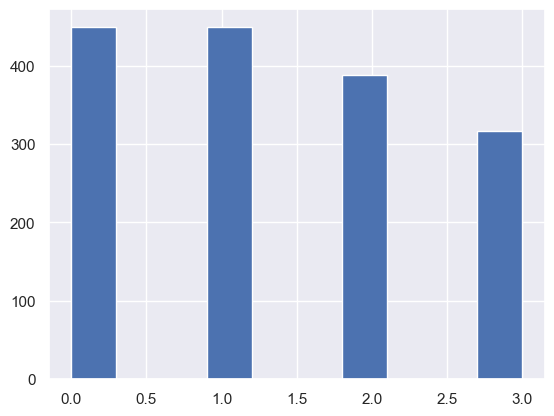

In [76]:
if OVER_SAMPLING:
    ros = RandomOverSampler(sampling_strategy="minority", random_state=33)

    X_train_df, _ = ros.fit_resample(meta_train_df[in_columns], meta_train_df["ahi_category"])
    inds = ros.sample_indices_
    extra_inds = inds[len(meta_train_df):]
    Y_train_df = pd.concat([meta_train_df[out_columns], meta_train_df[out_columns].iloc[extra_inds, :]], axis=0, ignore_index=True)

    Y_train_df["ahi_category"].hist()

else:
    X_train_df: pd.DataFrame = meta_train_df[in_columns]
    Y_train_df: pd.DataFrame = meta_train_df[out_columns]   

In [77]:
X_test_df: pd.DataFrame = meta_test_df[in_columns]
Y_test_df: pd.DataFrame = meta_test_df[out_columns]

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

Y_train_clas = Y_train_df["ahi_category"].to_numpy().ravel()
Y_test_clas = Y_test_df["ahi_category"].to_numpy().ravel()

Y_train_reg = Y_train_df.drop("ahi_category", axis=1, inplace=False).to_numpy()
Y_test_reg = Y_test_df.drop("ahi_category", axis=1, inplace=False).to_numpy()

## Standardization:

In [78]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## PCA

Variance explained by first 1 principal components: 39.10%
Variance explained by first 6 principal components: 77.12%
Variance explained by first 11 principal components: 87.07%
Variance explained by first 16 principal components: 92.98%
Variance explained by first 21 principal components: 96.39%
Variance explained by first 26 principal components: 98.09%
Variance explained by first 31 principal components: 99.08%
Variance explained by first 36 principal components: 99.57%
Variance explained by first 41 principal components: 99.79%
Variance explained by first 46 principal components: 99.91%


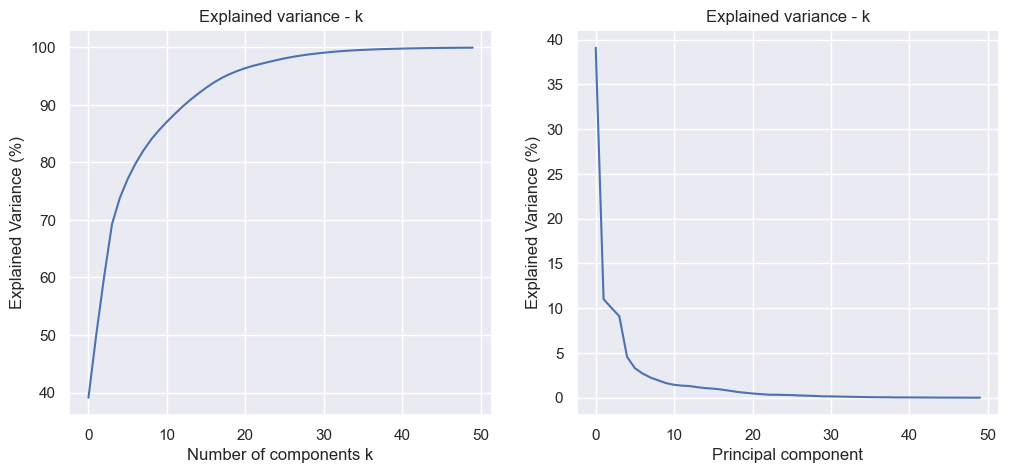

In [79]:
def PCA_plot(X_train, y_train, max_components=100, projection_plots=True, savefig=True):
    # https://towardsdatascience.com/11-dimensionality-reduction-techniques-you-should-know-in-2021-dcb9500d388b
    pca = PCA(n_components=max_components, random_state=33)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    var_explained_by_k = np.cumsum(pca.explained_variance_ratio_)

    for k in np.arange(start=1,stop=max_components+1, step=5):
        print(f"Variance explained by first {k} principal components: {100*var_explained_by_k[k-1]:.2f}%")

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

    axs[0].plot(100*var_explained_by_k)
    axs[0].set_title("Explained variance - k")
    axs[0].set_xlabel("Number of components k")
    axs[0].set_ylabel("Explained Variance (%)")

    axs[1].plot(100*pca.explained_variance_ratio_)
    axs[1].set_title("Explained variance - k")
    axs[1].set_xlabel("Principal component")
    axs[1].set_ylabel("Explained Variance (%)")

    if savefig:
        fig.savefig("elbow_pca_plt.png", dpi=100)
    plt.show()


    if projection_plots:
        plt.figure(figsize=(10,7))
        sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette="colorblind")
        plt.title(f"2D scatter plot: {100*var_explained_by_k[2]:.2f}% variance captured")
        plt.xlabel("First Principal Component")
        plt.ylabel("Second Principal Component")
        plt.savefig("pc1_pc2_plt.png", dpi=100)
        plt.show()

        fig = plt.figure(figsize = (15, 15))
        ax = plt.axes(projection ="3d")
        ax.scatter3D(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, alpha=0.5)
        plt.title(f"3D scatter plot: {100*var_explained_by_k[2]:.2f}% variance captured")
        ax.set_xlabel("First Principal Component")
        ax.set_ylabel("Second Principal Component")
        ax.set_zlabel("Third Principal Component")
        plt.savefig("pc1_pc2_pc3_plt.png", dpi=100)
        plt.show()

        plt.close()

n_features = len(in_columns)
PCA_plot(X_train=X_train, y_train=Y_train_clas, max_components=min(n_features,50), projection_plots=False, savefig=False)

pca = PCA(n_components=20, random_state=33)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


## Classification

### Baseline

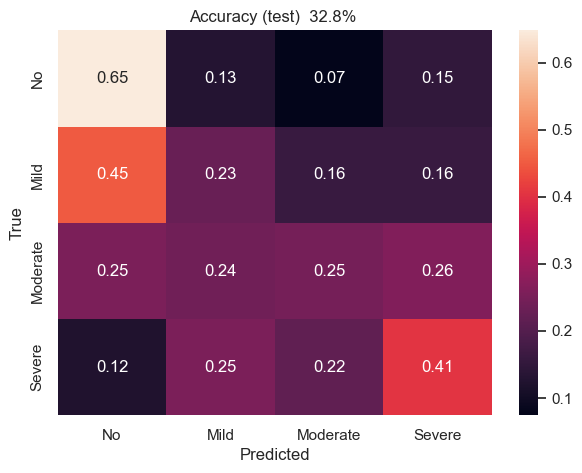

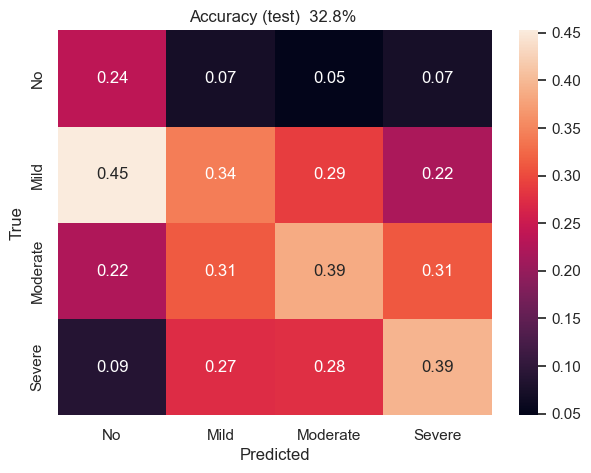

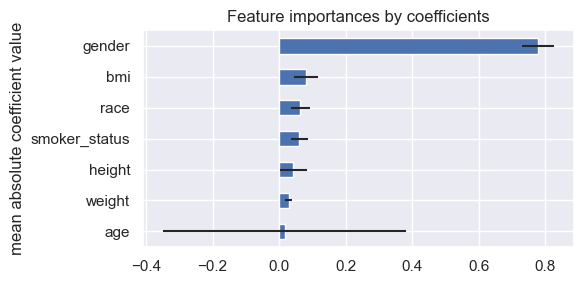

In [120]:
baseline = LogisticRegression(random_state=33, solver="newton-cg")
baseline.fit(X_train_df[metadata_columns].to_numpy(), Y_train_clas)
classification_performance(Y_test_clas, baseline.predict(X_test_df[metadata_columns].to_numpy()), test=True, plot_confusion=True, 
                           target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
classification_performance(Y_test_clas, baseline.predict(X_test_df[metadata_columns].to_numpy()), test=True, plot_confusion=True, 
                           target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

importances = np.mean(np.abs(baseline.coef_), axis=0)
std = np.std(np.abs(baseline.coef_), axis=0)
importances_s = pd.Series(importances, index=metadata_columns).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(6,3))
importances_s.plot.barh(xerr=std, ax=ax)
ax.set_title(f"Feature importances by coefficients")
ax.set_ylabel("mean absolute coefficient value")
fig.tight_layout()

### Model Selection

In [81]:
if CLASSIFICATION and not ONLY_LOGISTIC_RIDGE:
    models = [LogisticRegression(random_state=33, solver="newton-cg"), RandomForestClassifier(random_state=33), SVC(random_state=33), XGBClassifier(seed=33)]

    for model in models:
        scores = cross_validate(estimator=model, X=X_train, y=Y_train_clas, scoring="accuracy", cv=5)
        acc = np.mean(scores["test_score"])
        print(f"{model} -> {100*acc:2.2f}%")

### Logistic

In [82]:
if CLASSIFICATION:
    model = LogisticRegression(random_state=33)

    parameters = [{'penalty': ['l2'],
                'C': np.linspace(0.2,1.0, num=10, endpoint=True),
                'solver': ['newton-cg', 'newton-cholesky']},
                {'penalty': ['l1'],
                'C': np.linspace(0.2,1.0, num=10, endpoint=True),
                'solver': ['liblinear']},
                {'penalty': ['elasticnet'],
                'C': np.linspace(0.1,0.5, num=5, endpoint=True),
                'l1_ratio': np.linspace(0.2, 0.8, 7, endpoint=True),
                'solver': ['saga'],
                'max_iter': [300]}]
    clf = GridSearchCV(model, parameters, cv=5, scoring="accuracy", refit=True)
    
    clf.fit(X_train, Y_train_clas)

    print(clf.best_score_)
    best_logistic = clf.best_estimator_
    best_logistic_params = clf.best_params_
    print(best_logistic_params)

c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\filip\anaconda3\envs\apnea

0.5647607437936571
{'C': 0.2, 'penalty': 'l2', 'solver': 'newton-cg'}


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Recall


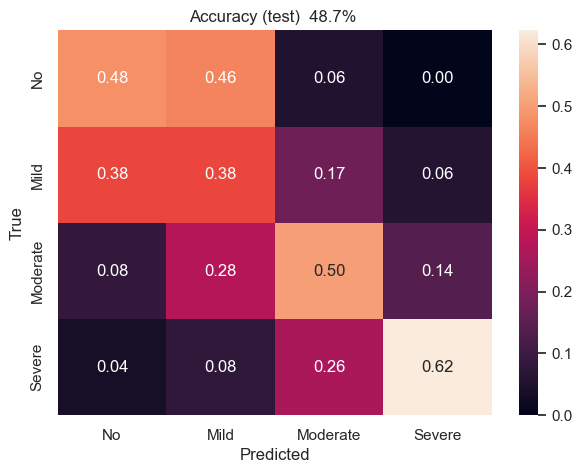

Precision


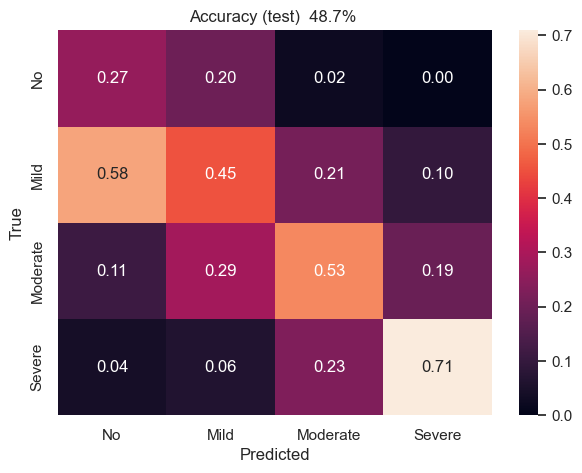

In [83]:
if CLASSIFICATION:
    print("Recall")
    classification_performance(Y_test_clas, best_logistic.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
    print("Precision")
    classification_performance(Y_test_clas, best_logistic.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

Test accuracy: 48.75%


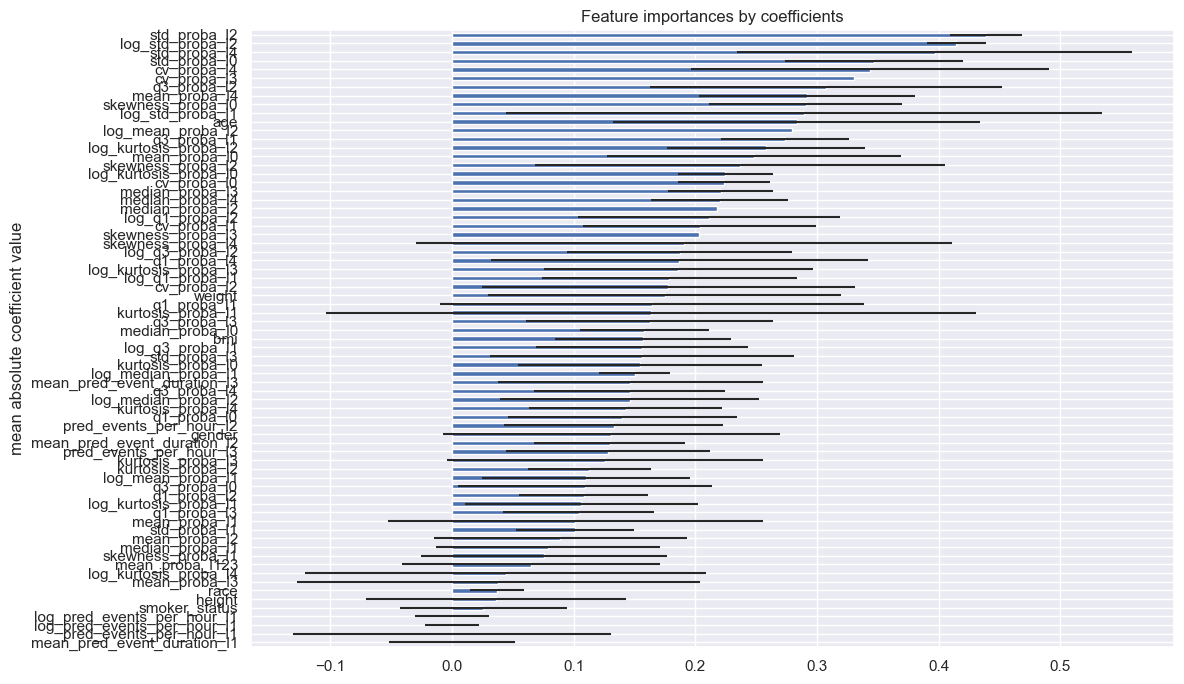

In [84]:
if CLASSIFICATION:
    print(f"Test accuracy: {100*accuracy_score(Y_test_clas, best_logistic.predict(X_test)):.2f}%")


    importances = np.mean(np.abs(best_logistic.coef_), axis=0)
    std = np.std(np.abs(best_logistic.coef_), axis=0)
    importances_s = pd.Series(importances, index=in_columns).sort_values(ascending=True)

    fig, ax = plt.subplots(figsize=(12,7))
    importances_s.plot.barh(xerr=std, ax=ax)
    ax.set_title(f"Feature importances by coefficients")
    ax.set_ylabel("mean absolute coefficient value")
    fig.tight_layout()

#### Logistic with PCA

In [85]:
if CLASSIFICATION:
    model = LogisticRegression(random_state=33)

    parameters = [{'penalty': ['l2'],
                'C': np.linspace(0.2,1.0, num=10, endpoint=True),
                'solver': ['newton-cg', 'newton-cholesky']},
                {'penalty': ['l1'],
                'C': np.linspace(0.2,1.0, num=10, endpoint=True),
                'solver': ['liblinear']},
                {'penalty': ['elasticnet'],
                'C': np.linspace(0.1,0.5, num=5, endpoint=True),
                'l1_ratio': np.linspace(0.2, 0.8, 7, endpoint=True),
                'solver': ['saga'],
                'max_iter': [300]}]
    clf = GridSearchCV(model, parameters, cv=5, scoring="accuracy", refit=True)
    
    clf.fit(X_train_pca, Y_train_clas)

    print(clf.best_score_)
    best_logistic = clf.best_estimator_
    best_logistic_params = clf.best_params_
    print(best_logistic_params)

c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\filip\anaconda3\envs\apnea

0.5311371683984443
{'C': 0.4, 'l1_ratio': 0.6000000000000001, 'max_iter': 300, 'penalty': 'elasticnet', 'solver': 'saga'}


Recall


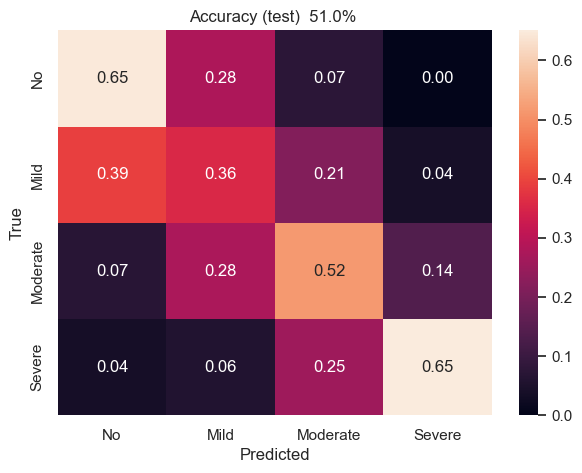

Precision


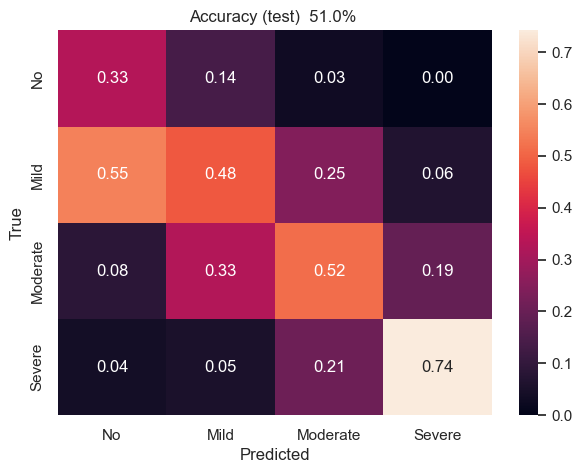

In [86]:
if CLASSIFICATION:
    print("Recall")
    classification_performance(Y_test_clas, best_logistic.predict(X_test_pca), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
    print("Precision")
    classification_performance(Y_test_clas, best_logistic.predict(X_test_pca), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

### SVC

In [87]:
if CLASSIFICATION and not ONLY_LOGISTIC_RIDGE:
    if True:
        model = SVC(random_state=33)

        parameters = {'degree': [2, 3, 4],
                    'gamma': ["scale", "auto"],
                    'C': np.linspace(0.1,1.0, num=20, endpoint=True),
                    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
        clf = GridSearchCV(model, parameters, cv=5, scoring="accuracy", refit=True)
        clf.fit(X_train, Y_train_clas)

        print(clf.best_score_)
        best_svm = clf.best_estimator_
        best_svm_params = clf.best_params_
        best_svm_params
    else:
        parameters = {'degree': 2,
                    'gamma': "scale",
                    'C': 0.1,
                    'kernel': 'rbf'}
        best_svm = SVC(random_state=33, **parameters)
        best_svm.fit(X_train, Y_train_clas)

        scores = cross_validate(estimator=best_svm, X=X_train, y=Y_train_clas, scoring='accuracy', cv=5)["test_score"]
        print(f"Mean cv accuracy: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}, CV: {100*np.std(scores)/abs(np.mean(scores)):2.2f}%")

In [88]:
if CLASSIFICATION and not ONLY_LOGISTIC_RIDGE:
    print("Recall")
    classification_performance(Y_test_clas, best_svm.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
    print("Precision")
    classification_performance(Y_test_clas, best_svm.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

### Random Forest

In [89]:
if CLASSIFICATION and not ONLY_LOGISTIC_RIDGE:
    if True:
        rf_clas = RandomForestClassifier(random_state=33)

        parameters = {'n_estimators':[100], 
                    'criterion': ['gini'],
                    'max_depth':[5, 7, 9],
                    'min_samples_split': [2, 3, 4],
                    'min_samples_leaf': [1, 2, 3, 4],
                    'max_features': ("sqrt", 'log2')}
        clf = GridSearchCV(rf_clas, parameters, cv=5, scoring="accuracy", refit=True)
        clf.fit(X_train, Y_train_clas)

        print(clf.best_score_)
        best_rfc = clf.best_estimator_
        best_params = clf.best_params_
        print(best_params)
    else:
        parameters = {'n_estimators': 200, 
                    'criterion': 'entropy',
                    'max_depth': 9,
                    'min_samples_split': 3,
                    'min_samples_leaf': 1,
                    'max_features': "sqrt"}
        best_rfc = RandomForestClassifier(random_state=33, **parameters)
        best_rfc.fit(X_train, Y_train_clas)
        scores = cross_validate(estimator=best_rfc, X=X_train, y=Y_train_clas, scoring='accuracy', cv=5)["test_score"]
        print(f"Mean cv accuracy: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}, CV: {100*np.std(scores)/abs(np.mean(scores)):2.2f}%")


In [90]:
if CLASSIFICATION and not ONLY_LOGISTIC_RIDGE:
    print("Recall")
    classification_performance(Y_test_clas, best_rfc.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
    print("Precision")
    classification_performance(Y_test_clas, best_rfc.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

In [91]:
if CLASSIFICATION and not ONLY_LOGISTIC_RIDGE:
    print(f"Test accuracy: {100*accuracy_score(Y_test_clas, best_rfc.predict(X_test)):.2f}%")

    importances = best_rfc.feature_importances_
    std = np.std([tree.feature_importances_ for tree in best_rfc.estimators_], axis=0)
    forest_importances = pd.Series(best_rfc.feature_importances_, index=in_columns).sort_values(ascending=True)

    fig, ax = plt.subplots(figsize=(12,7))
    forest_importances.plot.barh(xerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

### XGBoost

In [92]:
if CLASSIFICATION and not ONLY_LOGISTIC_RIDGE:
    if True:
        xgbc = XGBClassifier(seed=33)

        parameters = {'eta': [0.1,0.2,0.3], 
                    'gamma': [0, 0.05, 0.1],
                    'max_depth':[4, 5, 6],
                    'subsample': [0.7, 0.8, 0.9],
                    'colsample_bytree': [0.7, 0.8, 0.9],
                    'colsample_bynode': [0.7, 0.8, 0.9],
                    'lambda': np.arange(0.7,1.0,0.1),
                    'alpha': np.arange(0.7, 1.0,0.1)}

        clf = RandomizedSearchCV(xgbc, parameters, cv=5, n_iter=100, scoring="accuracy", refit=True)
        clf.fit(X_train, Y_train_clas)

        print(clf.best_score_)
        xgbc = clf.best_estimator_
        best_params = clf.best_params_
        print(best_params)
    else:
        parameters = {'subsample': 0.9,
                    'max_depth': 6,
                    'lambda': 0.8,
                    'gamma': 0.1,
                    'eta': 0.2,
                    'colsample_bytree': 0.7,
                    'colsample_bynode': 0.9,
                    'alpha': 0.9}    
        xgbc = XGBClassifier(random_state=33, **parameters)
        xgbc.fit(X_train, Y_train_clas)
        scores = cross_validate(estimator=xgbc, X=X_train, y=Y_train_clas, scoring='accuracy', cv=5)["test_score"]
        print(f"Mean cv accuracy: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}, CV: {100*np.std(scores)/abs(np.mean(scores)):2.2f}%")

In [93]:
if CLASSIFICATION and not ONLY_LOGISTIC_RIDGE:
    classification_performance(Y_test_clas, xgbc.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
    classification_performance(Y_test_clas, xgbc.predict(X_test), test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

## Regression

In [94]:
def ahi_to_category(ahi: float) -> int:
    if ahi < 5.0:
        # No
        return 0
    elif ahi < 15.0:
        # Mild
        return 1
    elif ahi < 30.0:
        # Moderate
        return 2
    else:
        # Severe
        return 3

ahi_to_category_vf = np.vectorize(ahi_to_category)    

In [95]:
Y_train_reg.shape

(1606, 13)

In [96]:
Y_scaler = StandardScaler()
Y_scaler.fit(Y_train_reg)
Y_train_reg_scaled = Y_scaler.transform(Y_train_reg)

models = {"lr": LinearRegression(), "ridge": Ridge(), "svr": SVR(), "rf": RandomForestRegressor(random_state=33), "xgb": XGBRegressor(seed=33)}

cv_splitter = [(train_indices, validation_indices) for (train_indices, validation_indices) in StratifiedKFold(n_splits=5).split(X_train, y=Y_train_clas)]

if REGRESSION and not ONLY_LOGISTIC_RIDGE:
    for name, model in models.items():
        print(f"Model: {name}")
        for i, var in enumerate(regression_columns):
            scores = cross_validate(estimator=model, X=X_train, y=Y_train_reg_scaled[:,i], scoring='r2', cv=cv_splitter)["test_score"]
            print(f"Target: {var} -> Mean score: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}, CV: {100*np.std(scores)/abs(np.mean(scores)):2.2f}%")


train_mask_index_ahi_above_5 = (Y_train_reg[:,ahi_index] >= 5)
test_mask_index_ahi_above_5 = (Y_test_reg[:,ahi_index] >= 5)

X_train_ahi_over_5 = X_train[train_mask_index_ahi_above_5, :]
Y_train_reg_ahi_over_5 = Y_train_reg[train_mask_index_ahi_above_5, :]
Y_train_clas_ahi_over_5  = Y_train_clas[train_mask_index_ahi_above_5]

X_test_ahi_over_5 = X_test[test_mask_index_ahi_above_5, :]
Y_test_reg_ahi_over_5 = Y_test_reg[test_mask_index_ahi_above_5, :]
Y_test_clas_ahi_over_5  = Y_test_clas[test_mask_index_ahi_above_5]
cv_splitter_ahi_over_5 = [(train_indices, validation_indices) for (train_indices, validation_indices) in StratifiedKFold(n_splits=5).split(X_train_ahi_over_5, y=Y_train_clas_ahi_over_5)]       

### Ridge

In [97]:
if REGRESSION:
    model = Ridge(random_state=33)

    parameters = {'alpha': np.linspace(1.0,50.0, num=100, endpoint=True)}
    clf = GridSearchCV(model, parameters, cv=cv_splitter, scoring="r2", refit=True)
    clf.fit(X_train, Y_train_reg[:,ahi_index])

    print(clf.best_score_)
    best_ridge = clf.best_estimator_
    best_ridge_params = clf.best_params_
    best_ridge_params

0.6071793899512627


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.63
MAE: 7.77
CV(RMSE): 50.76%
---------------------------------------------------------------
Macro F1-score: 0.58


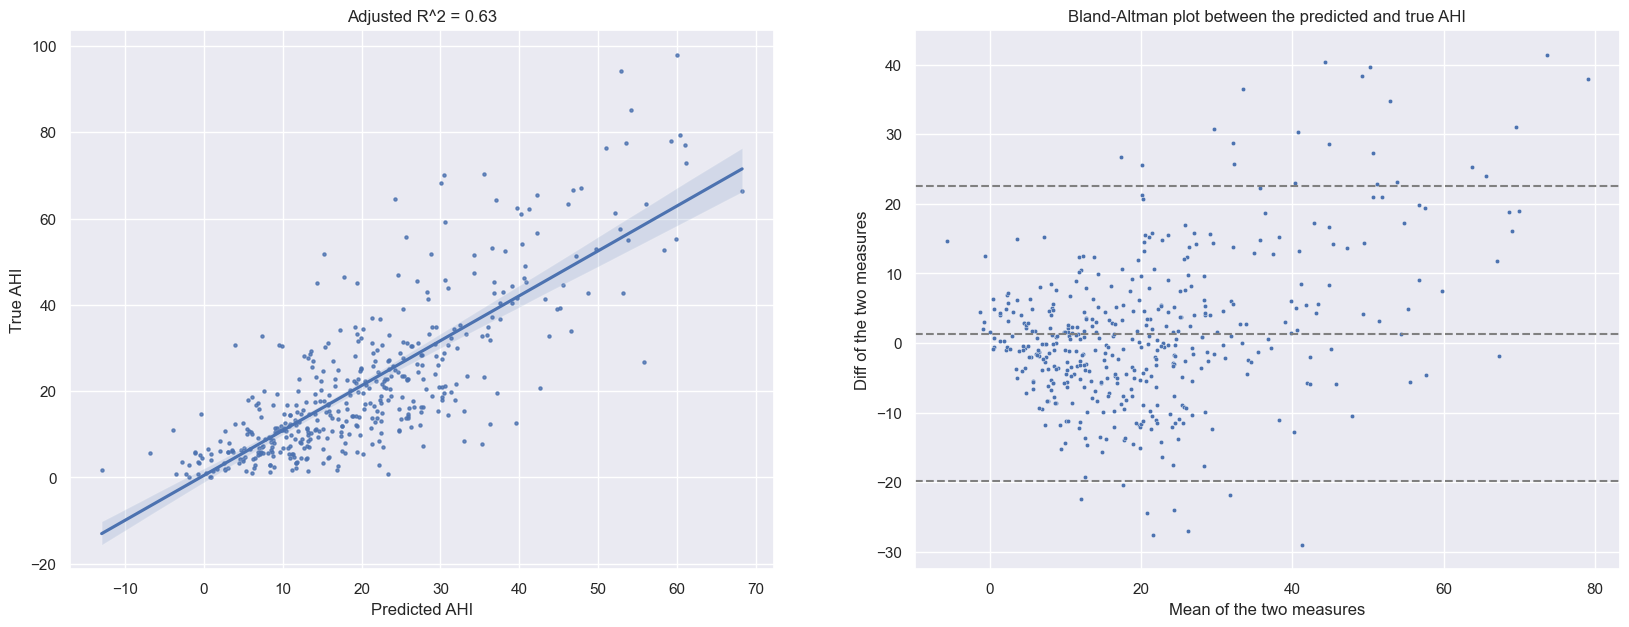

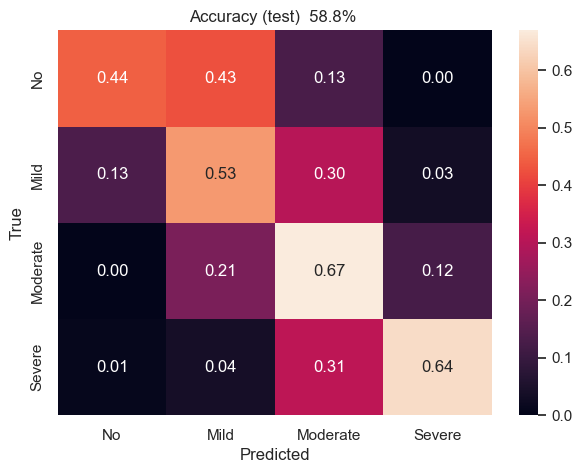

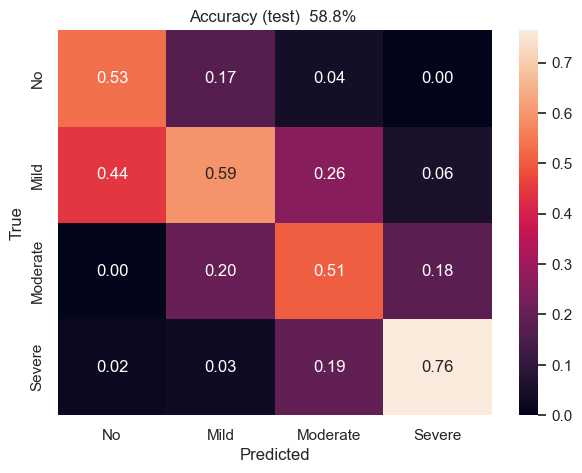

In [98]:
if REGRESSION:
    mdl = best_ridge

    y_hat = mdl.predict(X_test)
    y_true = Y_test_reg[:,ahi_index]

    y_hat_clas = ahi_to_category_vf(y_hat)
    y_true_clas = Y_test_clas
    
    r2 = r2_score(y_true=y_true, y_pred=y_hat)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_hat)
    rmse = mean_squared_error(y_true=y_true, y_pred=y_hat, squared=False)
    y_mean = np.mean(y_true)
    accuracy = accuracy_score(y_true=y_true_clas, y_pred=y_hat_clas)
    macro_f1 = f1_score(y_true=y_true_clas, y_pred=y_hat_clas, average="macro")

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
    sns_df = pd.DataFrame({"Predicted AHI": y_hat, "True AHI": y_true})
    sns.regplot(data=sns_df, x="Predicted AHI", y="True AHI", scatter_kws={"s": 5}, ax=axs[0])
    axs[0].set_title(f"Adjusted R^2 = {r2:.2f}")
    bland_altman_plot(y_true, y_hat, title="Bland-Altman plot between the predicted and true AHI", ax=axs[1], kwargs={"s": 10})

    print(f"Test adjusted R^2: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"CV(RMSE): {100*rmse/y_mean:.2f}%")
    print("---------------------------------------------------------------")
    print(f"Macro F1-score: {macro_f1:.2f}")
    classification_performance(y_true_clas, y_hat_clas, test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
    classification_performance(y_true_clas, y_hat_clas, test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

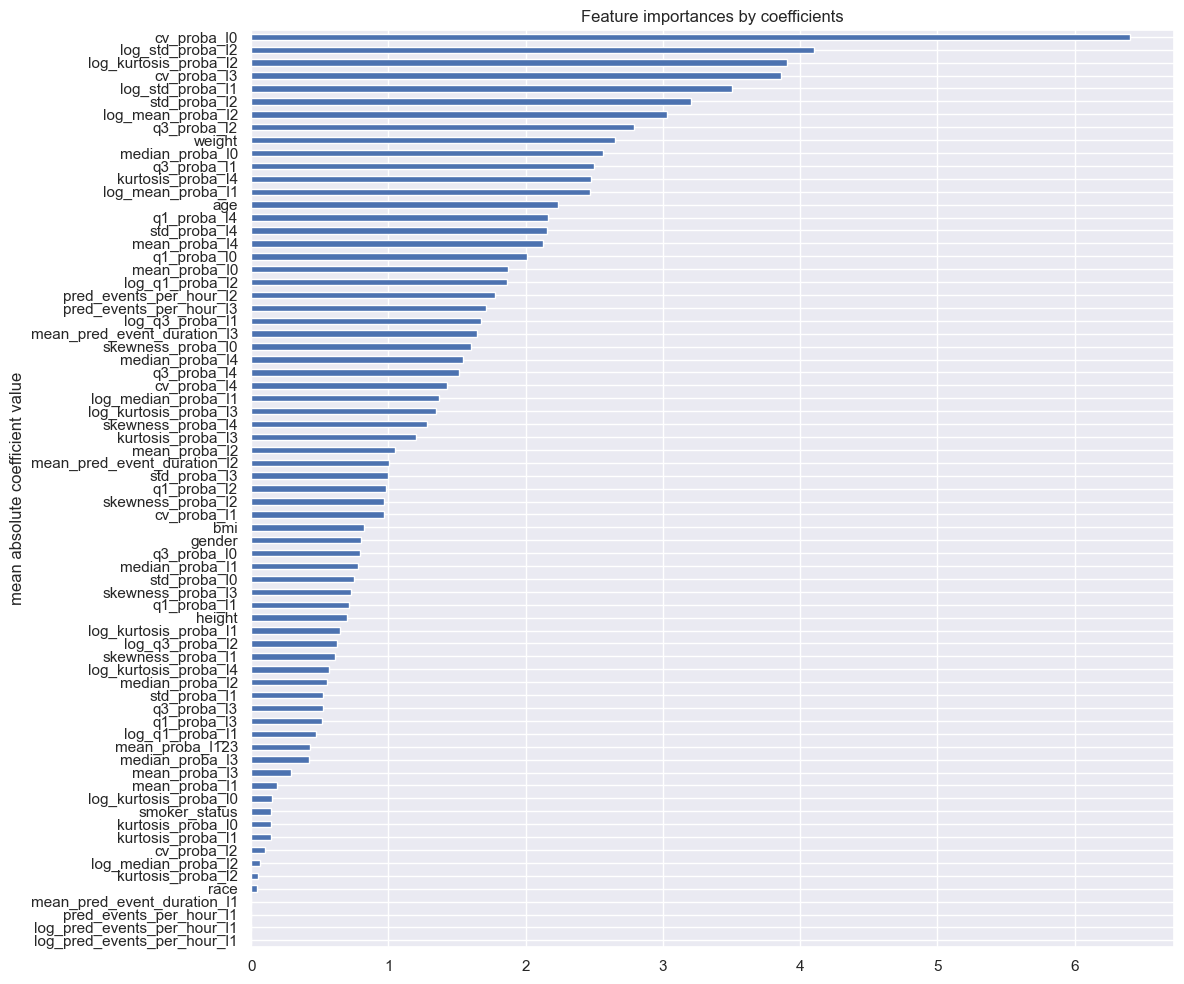

In [99]:
if REGRESSION:
    importances = best_ridge.coef_
    importances_s = pd.Series(importances, index=in_columns).sort_values(ascending=True, key= lambda x: np.abs(x))

    fig, ax = plt.subplots(figsize=(12,10))
    importances_s.plot.barh(ax=ax)
    ax.set_title(f"Feature importances by coefficients")
    ax.set_xlabel("Coefficient value")
    ax.set_ylabel("Feature")
    fig.tight_layout()

-------------------------------------------------
Regression on norm_duration_l0
Test adjusted R^2: 0.59
MAE: 0.07
CV(RMSE): 12.85%
-------------------------------------------------
Regression on norm_duration_l1
Test adjusted R^2: -0.11
MAE: 0.00
CV(RMSE): 363.48%
-------------------------------------------------
Regression on norm_duration_l2
Test adjusted R^2: 0.31
MAE: 0.01
CV(RMSE): 190.35%
-------------------------------------------------
Regression on norm_duration_l3
Test adjusted R^2: 0.13
MAE: 0.03
CV(RMSE): 63.82%
-------------------------------------------------
Regression on norm_duration_l4
Test adjusted R^2: 0.55
MAE: 0.06
CV(RMSE): 32.11%
-------------------------------------------------
Regression on ahi_a0h3a
Test adjusted R^2: 0.63
MAE: 7.77
CV(RMSE): 50.76%
-------------------------------------------------
Regression on ahi_c0h3a
Test adjusted R^2: 0.52
MAE: 6.96
CV(RMSE): 53.70%
-------------------------------------------------
Regression on ahi_o0h3a
Test adjusted

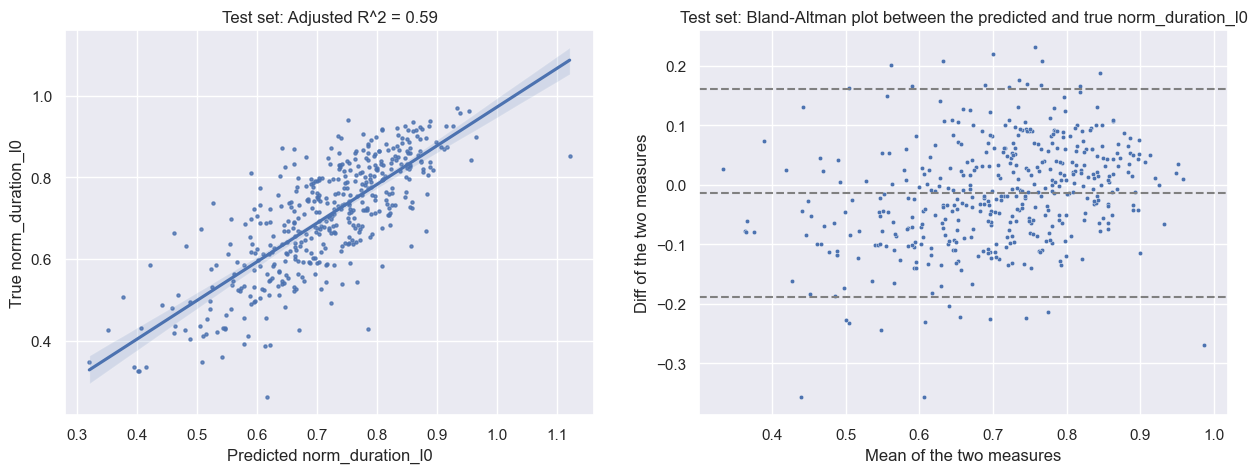

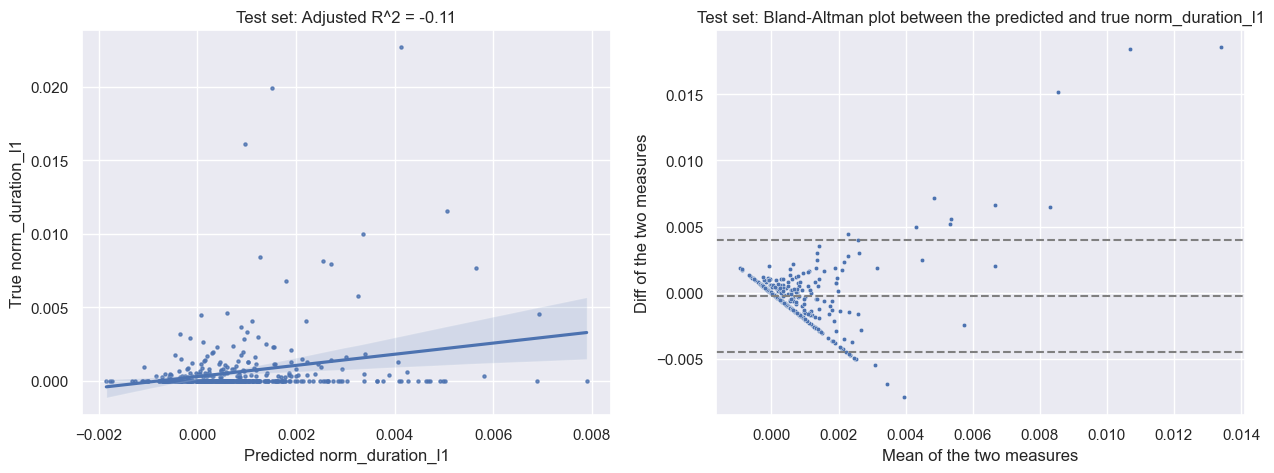

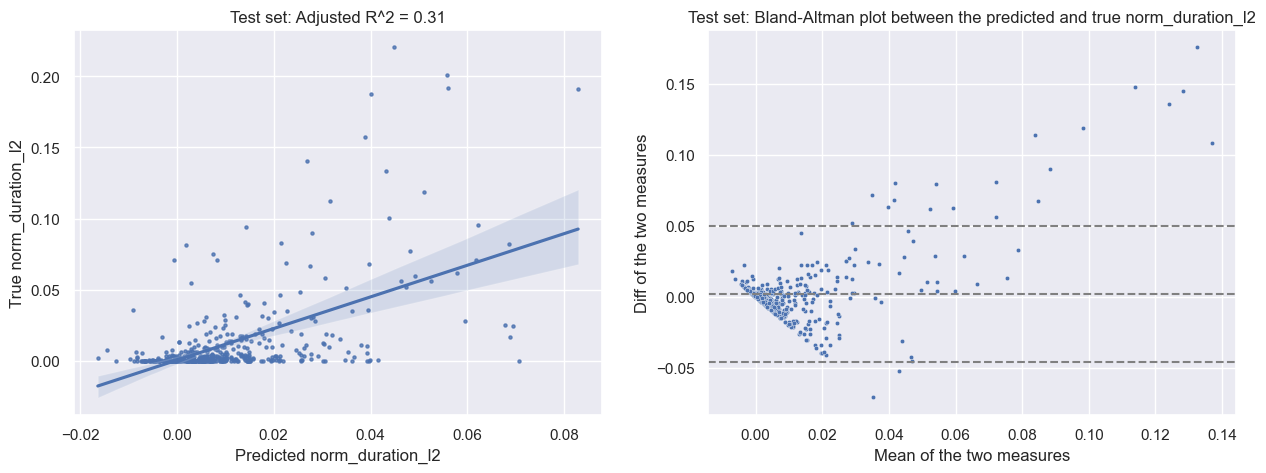

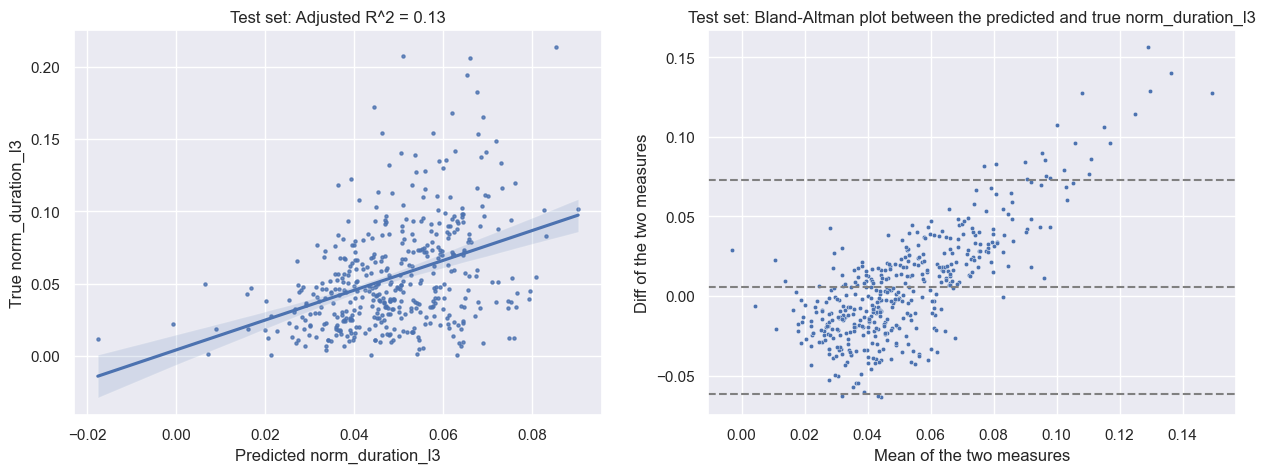

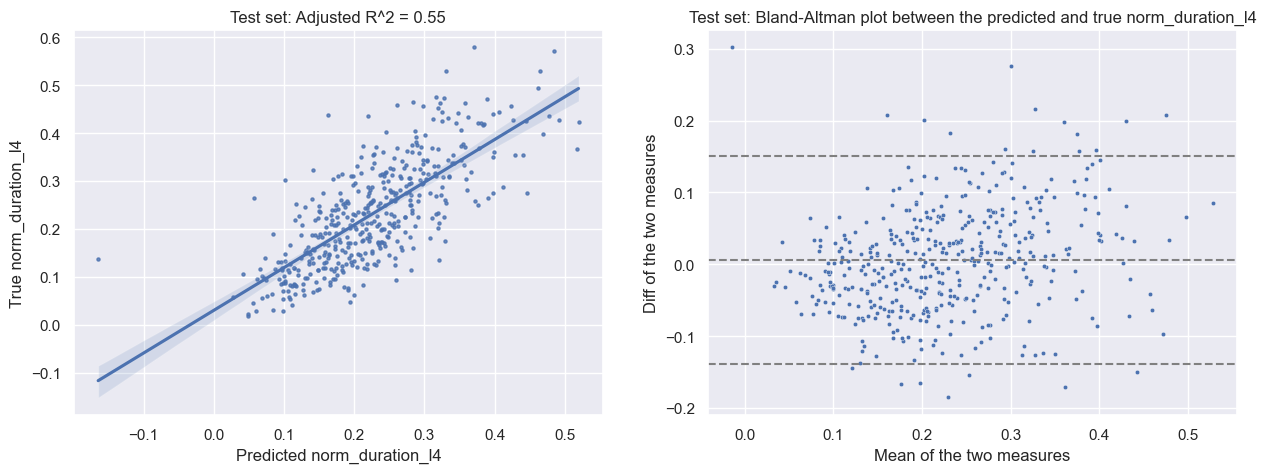

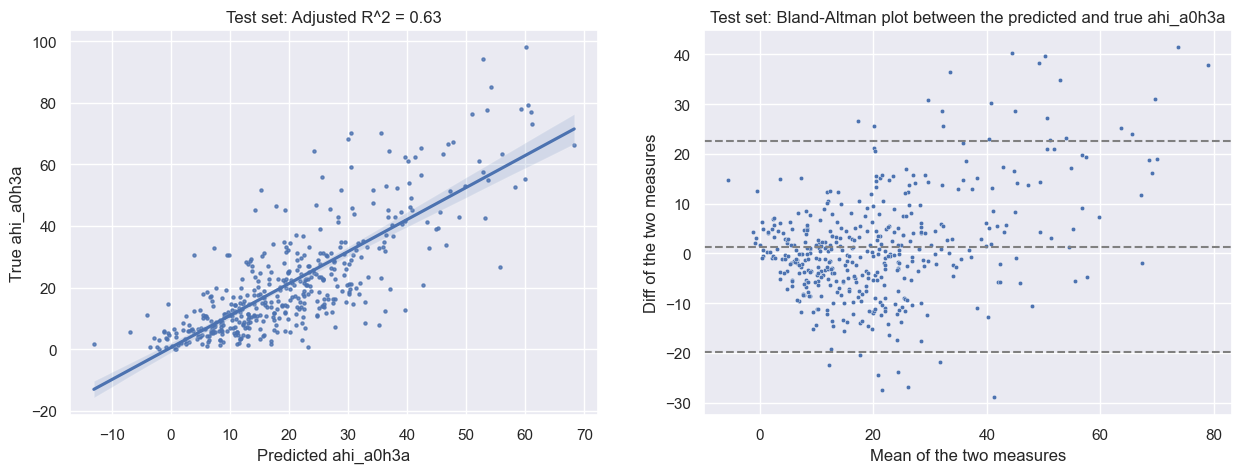

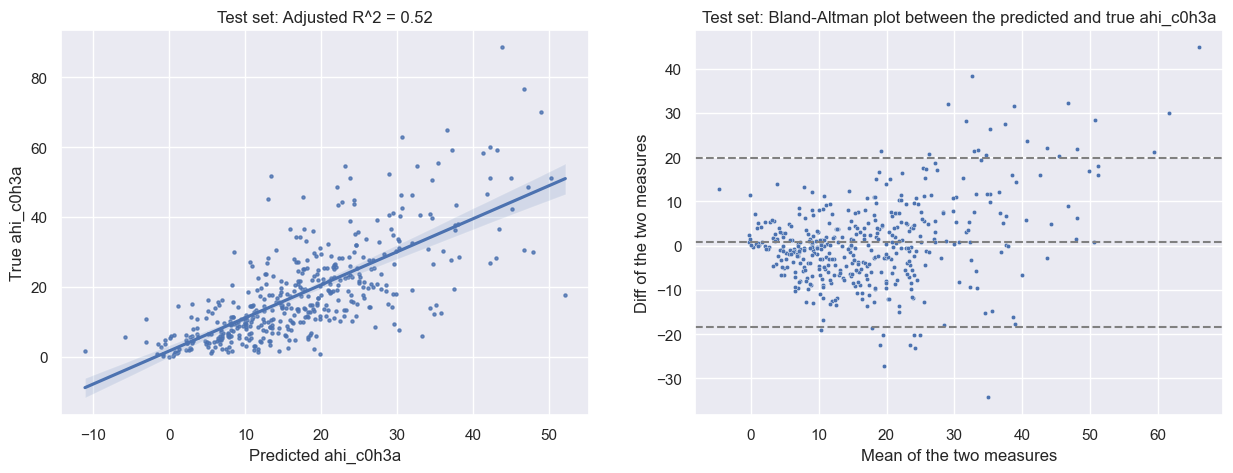

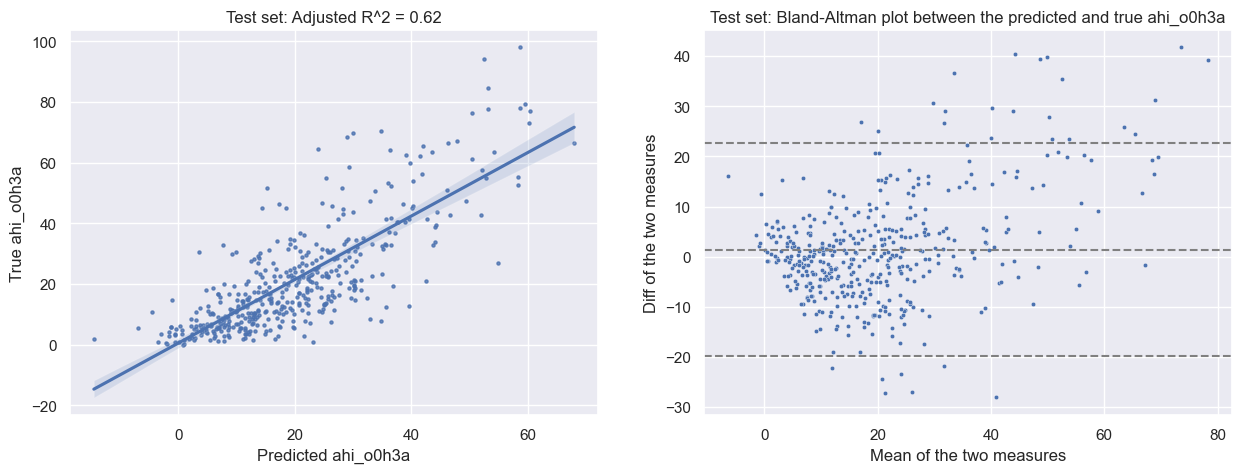

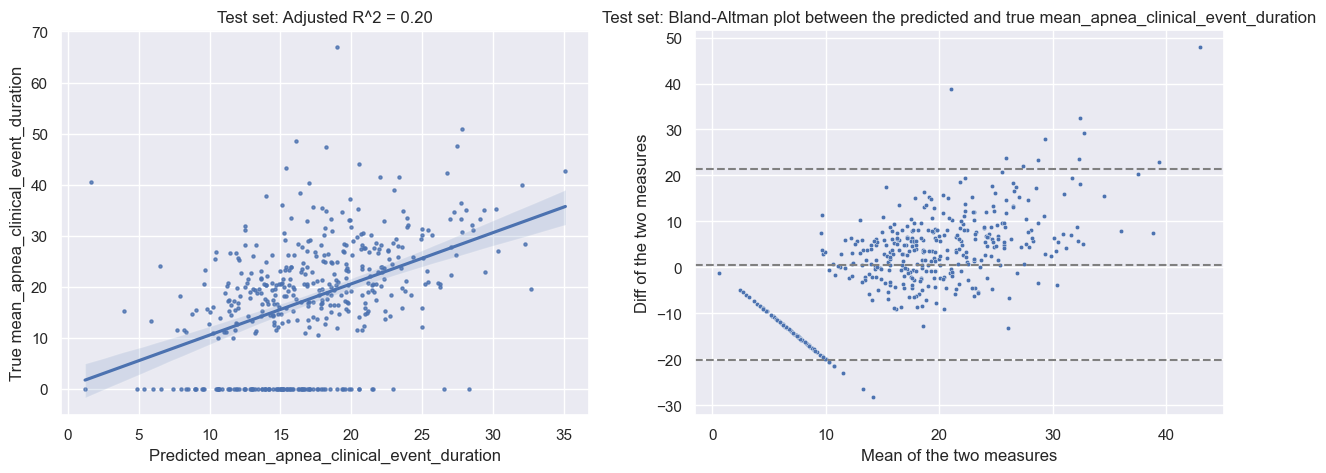

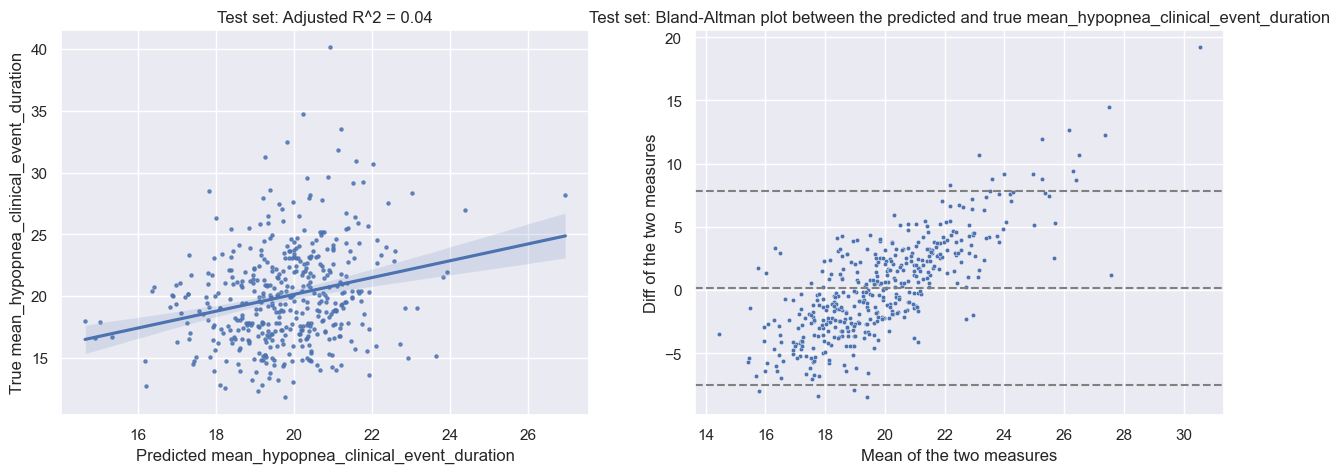

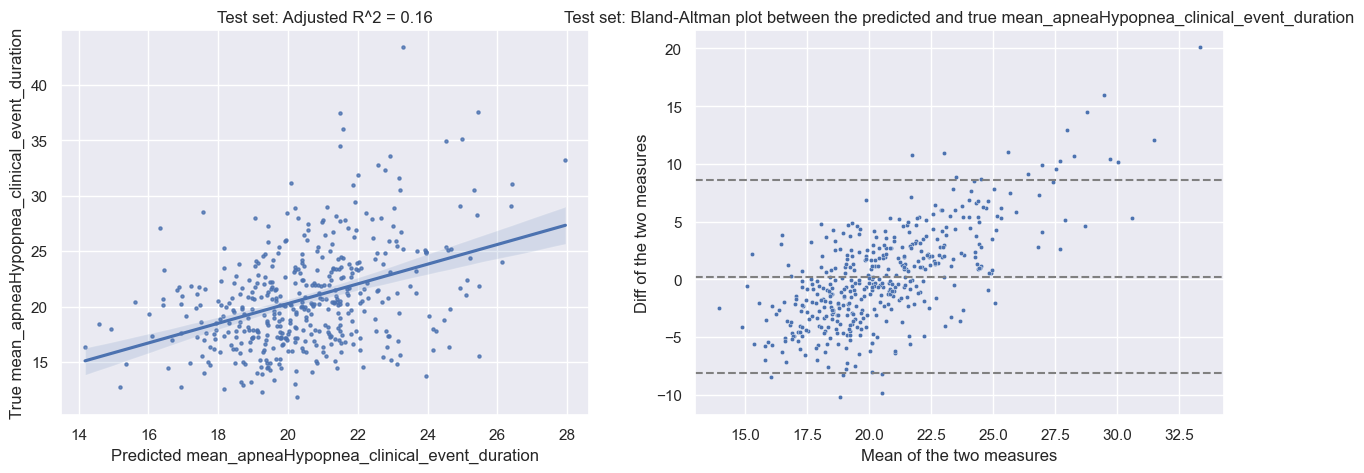

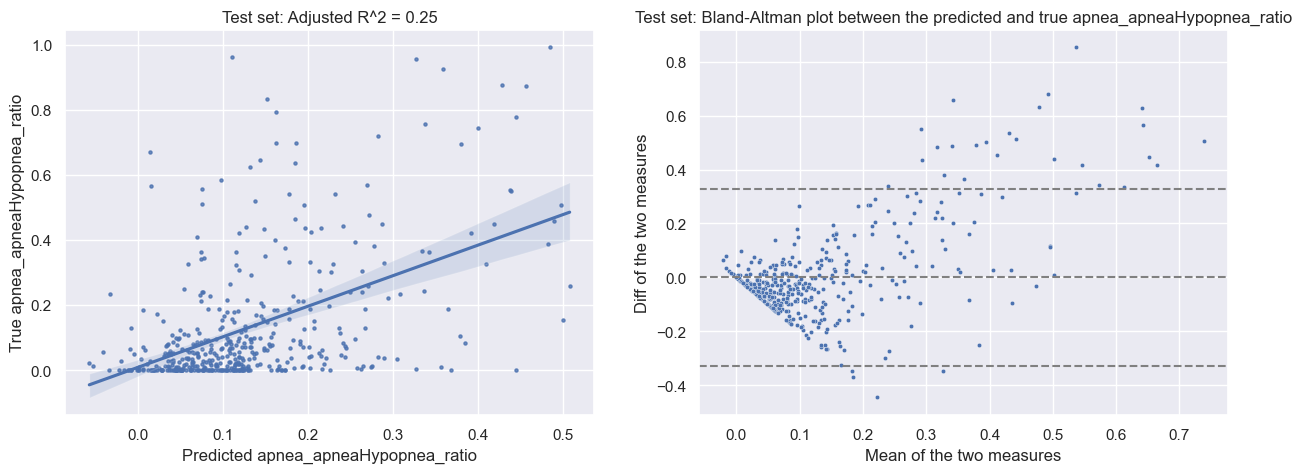

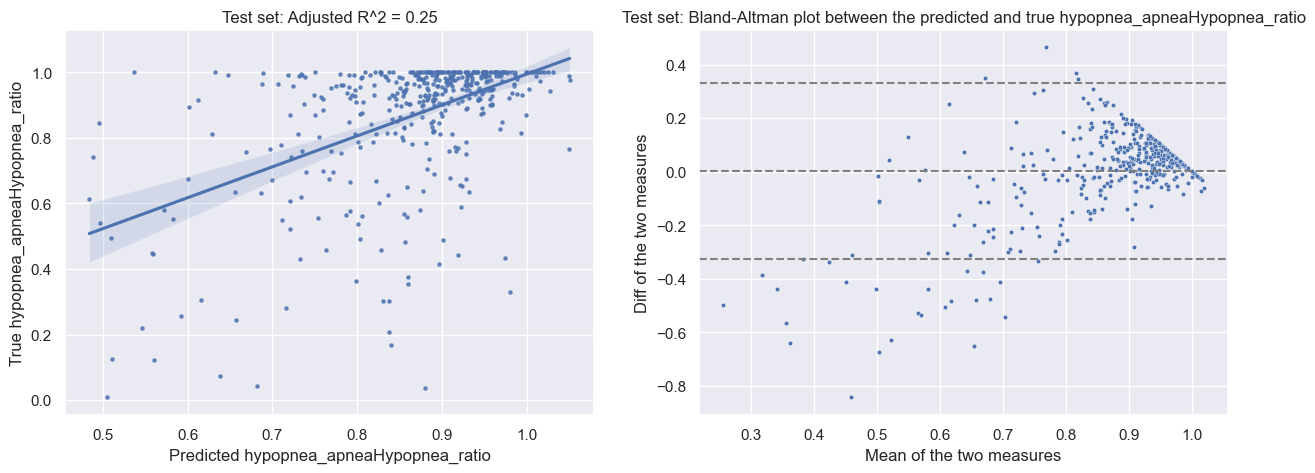

In [100]:
if REGRESSION:

    for i in range(len(regression_columns)):
        print("-------------------------------------------------")
        column_name = regression_columns[i]
        print(f"Regression on {column_name}")
        model = Ridge(random_state=33)

    
        parameters = {'alpha': np.linspace(1.0,50.0, num=100, endpoint=True)}
        clf = GridSearchCV(model, parameters, cv=cv_splitter, scoring="r2", refit=True)
        clf.fit(X_train, Y_train_reg[:, i])

        mdl = clf.best_estimator_

        y_hat = mdl.predict(X_test)
        y_true = Y_test_reg[:, i]

        y_hat_clas = ahi_to_category_vf(y_hat)
        y_true_clas = Y_test_clas
        
        r2 = r2_score(y_true=y_true, y_pred=y_hat)
        mae = mean_absolute_error(y_true=y_true, y_pred=y_hat)
        rmse = root_mean_squared_error(y_true=y_true, y_pred=y_hat)
        y_mean = np.mean(y_true)
        accuracy = accuracy_score(y_true=y_true_clas, y_pred=y_hat_clas)
        macro_f1 = f1_score(y_true=y_true_clas, y_pred=y_hat_clas, average="macro")

        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        sns_df = pd.DataFrame({f"Predicted {column_name}": y_hat, f"True {column_name}": y_true})
        sns.regplot(data=sns_df, x=f"Predicted {column_name}", y=f"True {column_name}", scatter_kws={"s": 5}, ax=axs[0])
        axs[0].set_title(f"Test set: Adjusted R^2 = {r2:.2f}")
        bland_altman_plot(y_true, y_hat, title=f"Test set: Bland-Altman plot between the predicted and true {column_name}", ax=axs[1], kwargs={"s": 10})

        print(f"Test adjusted R^2: {r2:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"CV(RMSE): {100*rmse/y_mean:.2f}%")

### SVR

In [101]:
if REGRESSION and not ONLY_LOGISTIC_RIDGE:
    Y_scaler_ahi = StandardScaler()
    Y_scaler_ahi.fit(Y_train_reg[:,ahi_index].reshape(-1,1))
    Y_train_ahi_scaled = Y_scaler_ahi.transform(Y_train_reg[:,ahi_index].reshape(-1,1)).ravel()
    if True:
        model = SVR()

        parameters = {'degree': [2, 3],
                    'gamma': ['scale', 'auto'],
                    'C': np.linspace(0.5,2.0, num=15, endpoint=True),
                    'kernel': ['linear', 'rbf', 'sigmoid']}
        clf = GridSearchCV(model, parameters, cv=cv_splitter, scoring="r2", refit=True)
        clf.fit(X_train, Y_train_ahi_scaled)

        print(clf.best_score_)
        best_svr= clf.best_estimator_
        best_svr_params = clf.best_params_
        print(best_svr_params)
    else:
        parameters = {'C': 2.0, 
                    'degree': 2, 
                    'gamma': 'auto', 
                    'kernel': 'rbf'}
        best_svr = SVR(**parameters)
        best_svr.fit(X_train, Y_train_ahi_scaled)
        scores = cross_validate(estimator=best_svr, X=X_train, y=Y_train_ahi_scaled, scoring='r2', cv=5)["test_score"]

In [102]:
if REGRESSION and not ONLY_LOGISTIC_RIDGE:
    y_hat = Y_scaler_ahi.inverse_transform(best_svr.predict(X_test).reshape(-1,1)).ravel()
    y_true = Y_test_reg[:,ahi_index]

    y_hat_clas = ahi_to_category_vf(y_hat)
    y_true_clas = Y_test_clas

    r2 = r2_score(y_true=y_true, y_pred=y_hat)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_hat)
    rmse = mean_squared_error(y_true=y_true, y_pred=y_hat, squared=False)
    y_mean = np.mean(y_true)
    accuracy = accuracy_score(y_true=y_true_clas, y_pred=y_hat_clas)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    sns_df = pd.DataFrame({"Predicted AHI": y_hat, "True AHI": y_true})
    sns.regplot(data=sns_df, x="Predicted AHI", y="True AHI", scatter_kws={"s": 5}, ax=axs[0])
    axs[0].set_title(f"Adjusted R^2 = {r2:.2f}")
    bland_altman_plot(y_true, y_hat, title="Bland-Altman plot between the predicted and true AHI", ax=axs[1], kwargs={"s": 10})
    
    print(f"Test R^2: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"CV(RMSE): {100*rmse/y_mean:.2f}%")
    print("---------------------------------------------------------------")
    classification_performance(y_true_clas, y_hat_clas, test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
    classification_performance(y_true_clas, y_hat_clas, test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

-------------------------------------------------
Regression on norm_duration_l0


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.59
MAE: 0.07
CV(RMSE): 12.83%
-------------------------------------------------
Regression on norm_duration_l1


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.06
MAE: 0.00
CV(RMSE): 334.53%
-------------------------------------------------
Regression on norm_duration_l2


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.22
MAE: 0.01
CV(RMSE): 202.47%
-------------------------------------------------
Regression on norm_duration_l3


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.05
MAE: 0.03
CV(RMSE): 66.91%
-------------------------------------------------
Regression on norm_duration_l4


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.56
MAE: 0.06
CV(RMSE): 31.65%
-------------------------------------------------
Regression on ahi_a0h3a


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.63
MAE: 7.64
CV(RMSE): 50.45%
-------------------------------------------------
Regression on ahi_c0h3a


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.51
MAE: 7.04
CV(RMSE): 54.49%
-------------------------------------------------
Regression on ahi_o0h3a


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.62
MAE: 7.74
CV(RMSE): 51.72%
-------------------------------------------------
Regression on mean_apnea_clinical_event_duration


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.14
MAE: 8.50
CV(RMSE): 61.80%
-------------------------------------------------
Regression on mean_hypopnea_clinical_event_duration


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: -0.07
MAE: 3.23
CV(RMSE): 20.72%
-------------------------------------------------
Regression on mean_apneaHypopnea_clinical_event_duration


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.10
MAE: 3.45
CV(RMSE): 21.26%
-------------------------------------------------
Regression on apnea_apneaHypopnea_ratio


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.20
MAE: 0.11
CV(RMSE): 132.68%
-------------------------------------------------
Regression on hypopnea_apneaHypopnea_ratio


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.21
MAE: 0.11
CV(RMSE): 19.84%


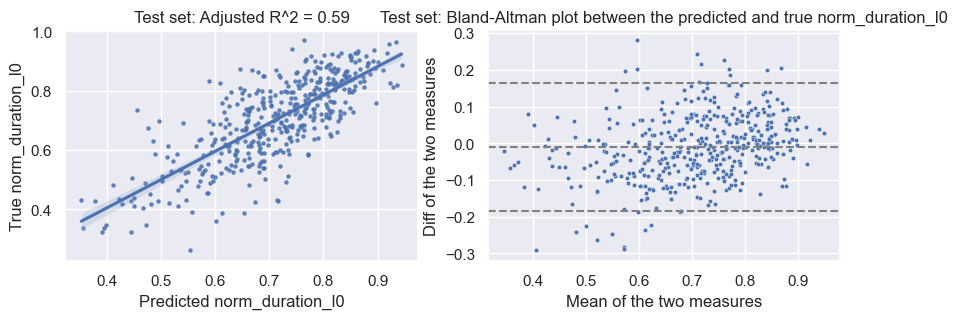

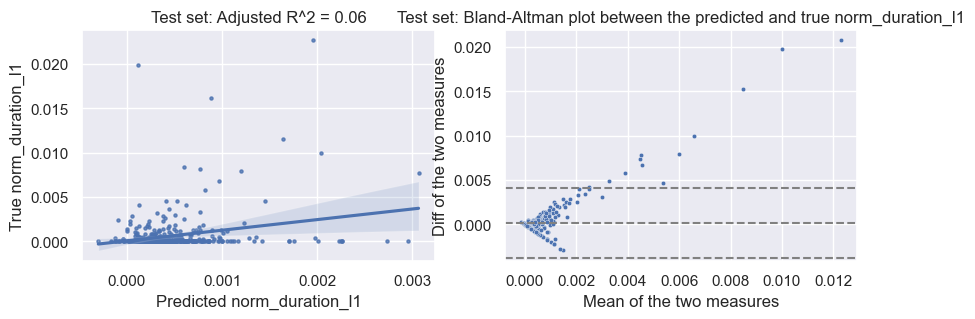

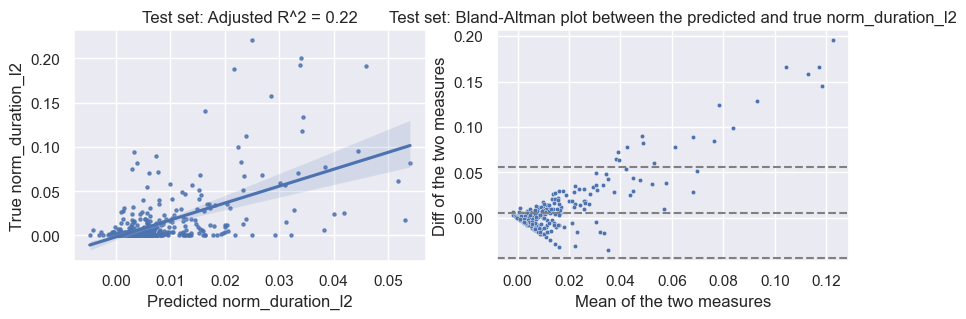

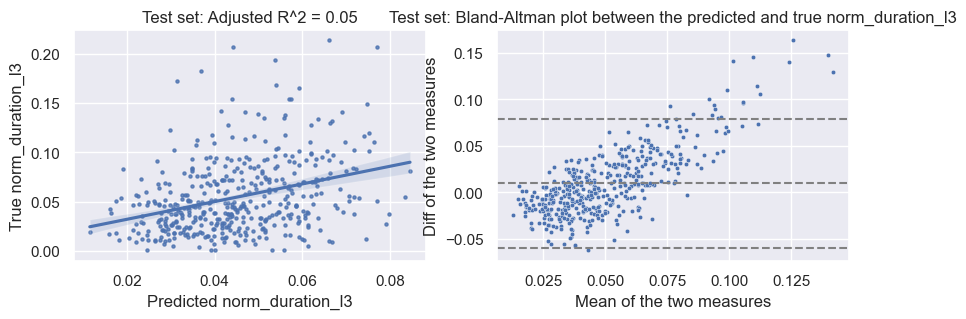

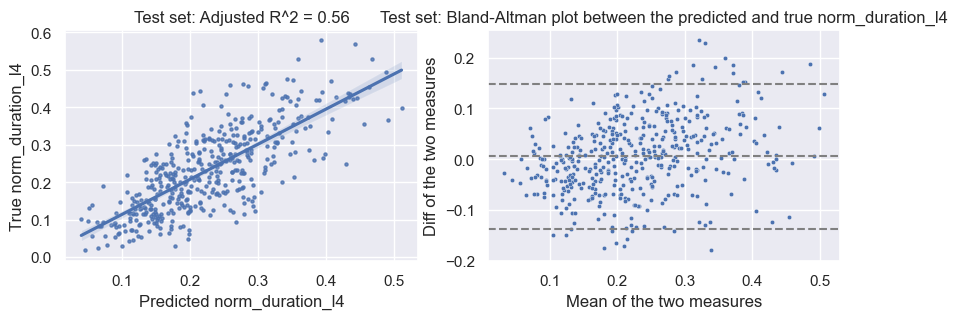

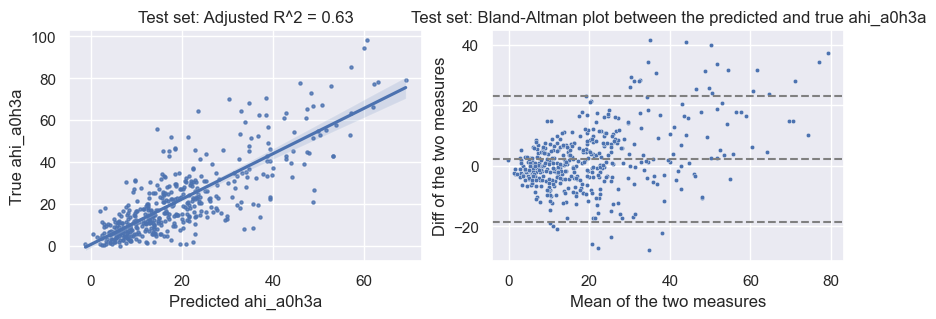

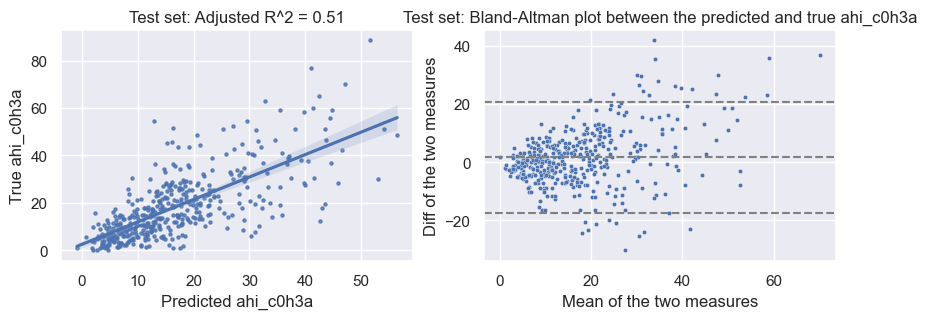

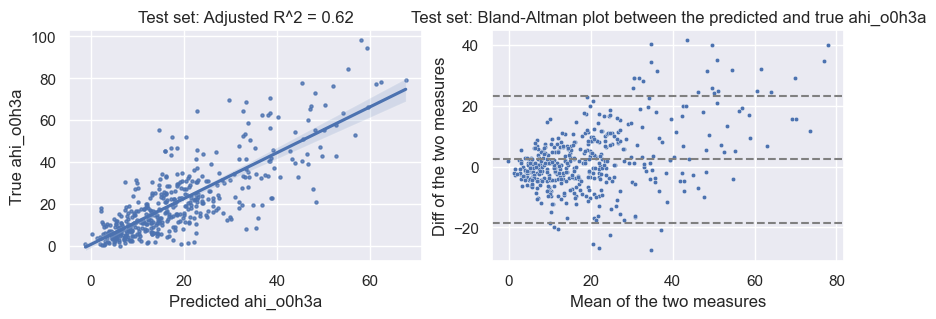

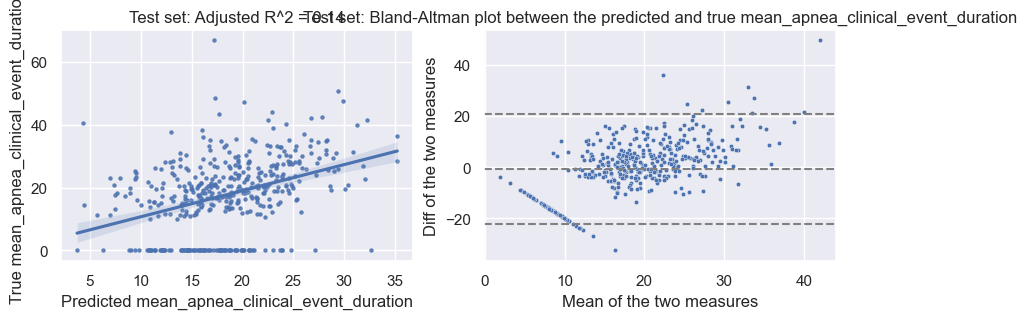

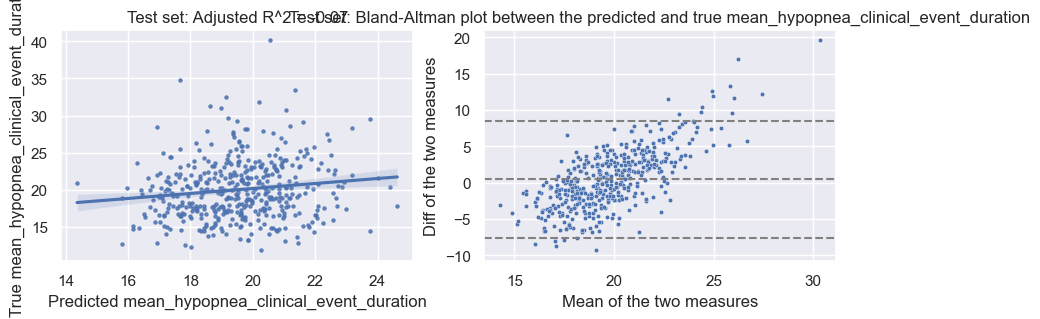

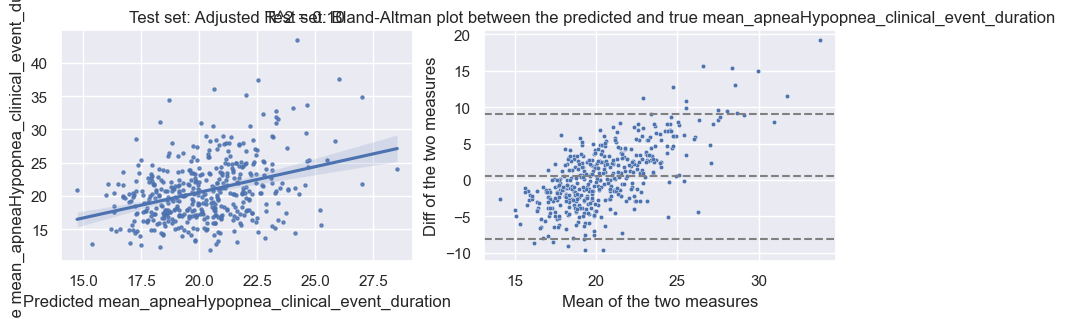

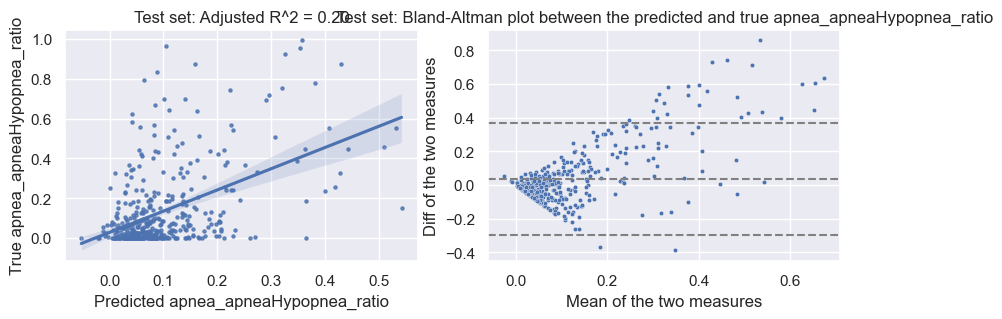

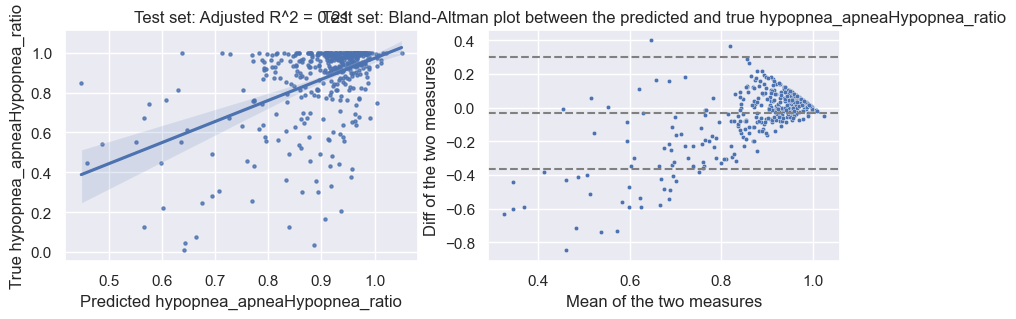

In [103]:
if REGRESSION:

    for i in range(len(regression_columns)):
        print("-------------------------------------------------")
        column_name = regression_columns[i]
        print(f"Regression on {column_name}")
    
        Y_scaler_col = StandardScaler()
        Y_scaler_col.fit(Y_train_reg[:,i].reshape(-1,1))
        Y_train_col_scaled = Y_scaler_col.transform(Y_train_reg[:,i].reshape(-1,1)).ravel()
        
        
        parameters = {'C': 1.0, 
                    'degree': 2, 
                    'gamma': 'auto', 
                    'kernel': 'rbf'}
        model = SVR(**parameters)
        model.fit(X_train, Y_train_col_scaled)
        mdl = model

        
        y_hat = mdl.predict(X_test)
        y_hat = Y_scaler_col.inverse_transform(y_hat.reshape(-1,1)).ravel()
        y_true = Y_test_reg[:, i]

        y_hat_clas = ahi_to_category_vf(y_hat)
        y_true_clas = Y_test_clas
        
        r2 = r2_score(y_true=y_true, y_pred=y_hat)
        mae = mean_absolute_error(y_true=y_true, y_pred=y_hat)
        rmse = mean_squared_error(y_true=y_true, y_pred=y_hat, squared=False)
        y_mean = np.mean(y_true)
        accuracy = accuracy_score(y_true=y_true_clas, y_pred=y_hat_clas)
        macro_f1 = f1_score(y_true=y_true_clas, y_pred=y_hat_clas, average="macro")

        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
        sns_df = pd.DataFrame({f"Predicted {column_name}": y_hat, f"True {column_name}": y_true})
        sns.regplot(data=sns_df, x=f"Predicted {column_name}", y=f"True {column_name}", scatter_kws={"s": 5}, ax=axs[0])
        axs[0].set_title(f"Test set: Adjusted R^2 = {r2:.2f}")
        bland_altman_plot(y_true, y_hat, title=f"Test set: Bland-Altman plot between the predicted and true {column_name}", ax=axs[1], kwargs={"s": 10})

        print(f"Test adjusted R^2: {r2:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"CV(RMSE): {100*rmse/y_mean:.2f}%")

### Random Forest Regression

In [104]:
if REGRESSION and not ONLY_LOGISTIC_RIDGE:
    if True:
        model = RandomForestRegressor(random_state=33)

        parameters = {'n_estimators':[100], 
                    'max_depth':[10, 15, 20, None],
                    'min_samples_split': [2, 3, 4],
                    'min_samples_leaf': [1, 2, 3],
                    'max_features': ("sqrt", 'log2')}

        clf = GridSearchCV(model, parameters, cv=cv_splitter, scoring="r2", refit=True)
        clf.fit(X_train, Y_train_reg[:,5])

        print(clf.best_score_)
        best_rfr = clf.best_estimator_
        best_rfr_params = clf.best_params_
        best_rfr_params
    else:
        parameters = {'max_depth': None,
                    'max_features': 'sqrt',
                    'min_samples_leaf': 1,
                    'min_samples_split': 4,
                    'n_estimators': 100} 
        best_rfr = RandomForestRegressor(random_state=33, **parameters)
        best_rfr.fit(X_train, Y_train_reg[:,ahi_index])
        scores = cross_validate(estimator=best_rfr, X=X_train, y=Y_train_reg[:,5], scoring='r2', cv=5)["test_score"]
        print(f"Mean cv r2: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}, CV: {100*np.std(scores)/abs(np.mean(scores)):2.2f}%")

In [105]:
if REGRESSION and not ONLY_LOGISTIC_RIDGE:
    mdl = best_rfr

    y_hat = mdl.predict(X_test)
    y_true = Y_test_reg[:,ahi_index]

    y_hat_clas = ahi_to_category_vf(y_hat)
    y_true_clas = Y_test_clas


    r2 = r2_score(y_true=y_true, y_pred=y_hat)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_hat)
    rmse = mean_squared_error(y_true=y_true, y_pred=y_hat, squared=False)
    y_mean = np.mean(y_true)
    accuracy = accuracy_score(y_true=y_true_clas, y_pred=y_hat_clas)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    sns_df = pd.DataFrame({"Predicted AHI": y_hat, "True AHI": y_true})
    sns.regplot(data=sns_df, x="Predicted AHI", y="True AHI", scatter_kws={"s": 5}, ax=axs[0])
    axs[0].set_title(f"Adjusted R^2 = {r2:.2f}")
    bland_altman_plot(y_true, y_hat, title="Bland-Altman plot between the predicted and true AHI", ax=axs[1], kwargs={"s": 10})

    print(f"Test R^2: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"CV(RMSE): {100*rmse/y_mean:.2f}%")
    print("---------------------------------------------------------------")
    classification_performance(y_true_clas, y_hat_clas, test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
    classification_performance(y_true_clas, y_hat_clas, test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

#### Regression on all columns

-------------------------------------------------
Regression on norm_duration_l0


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.56
MAE: 0.07
CV(RMSE): 13.31%
-------------------------------------------------
Regression on norm_duration_l1
Test adjusted R^2: -399.58
MAE: 0.04
CV(RMSE): 6892.53%
-------------------------------------------------
Regression on norm_duration_l2


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: -6.07
MAE: 0.08
CV(RMSE): 611.45%
-------------------------------------------------
Regression on norm_duration_l3


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: -1.08
MAE: 0.05
CV(RMSE): 98.70%
-------------------------------------------------
Regression on norm_duration_l4


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.52
MAE: 0.06
CV(RMSE): 33.15%
-------------------------------------------------
Regression on ahi_a0h3a


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.42
MAE: 8.97
CV(RMSE): 63.50%
-------------------------------------------------
Regression on ahi_c0h3a


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.39
MAE: 7.41
CV(RMSE): 60.70%
-------------------------------------------------
Regression on ahi_o0h3a


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.40
MAE: 8.98
CV(RMSE): 64.58%
-------------------------------------------------
Regression on mean_apnea_clinical_event_duration


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.14
MAE: 8.45
CV(RMSE): 61.73%
-------------------------------------------------
Regression on mean_hypopnea_clinical_event_duration


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: -0.01
MAE: 3.13
CV(RMSE): 20.15%
-------------------------------------------------
Regression on mean_apneaHypopnea_clinical_event_duration


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.10
MAE: 3.39
CV(RMSE): 21.25%
-------------------------------------------------
Regression on apnea_apneaHypopnea_ratio


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.17
MAE: 0.12
CV(RMSE): 135.43%
-------------------------------------------------
Regression on hypopnea_apneaHypopnea_ratio


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.16
MAE: 0.13
CV(RMSE): 20.39%


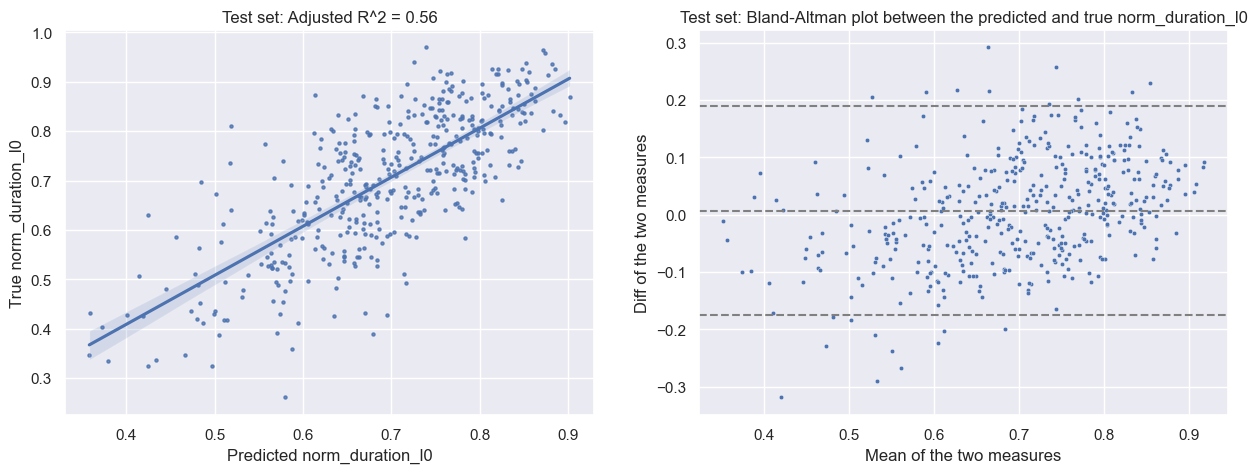

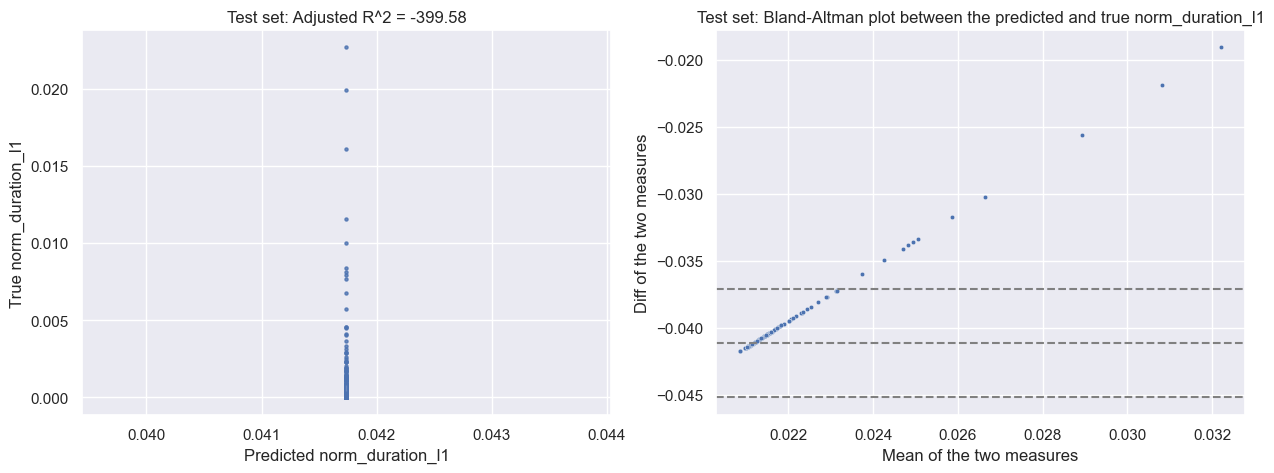

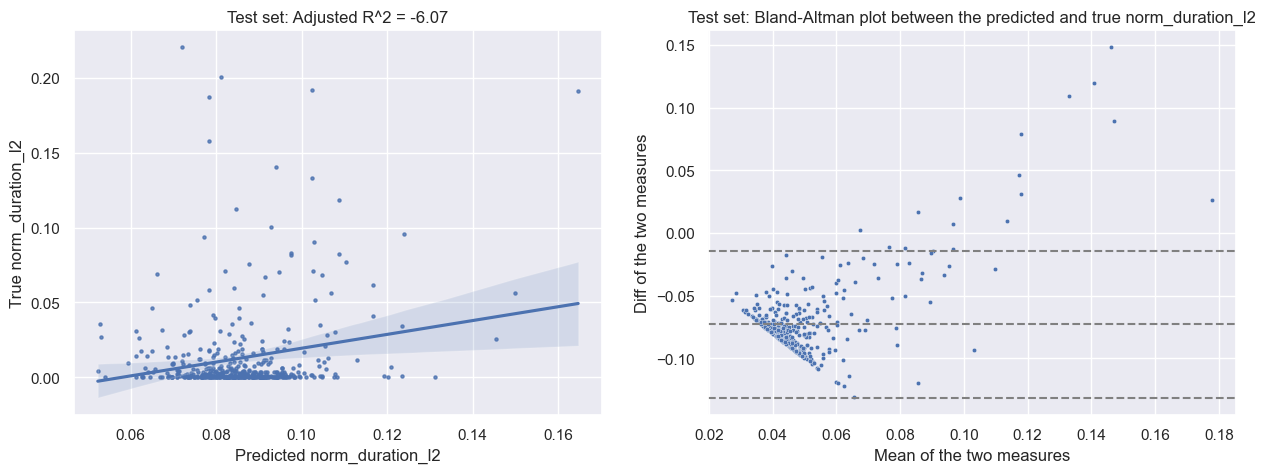

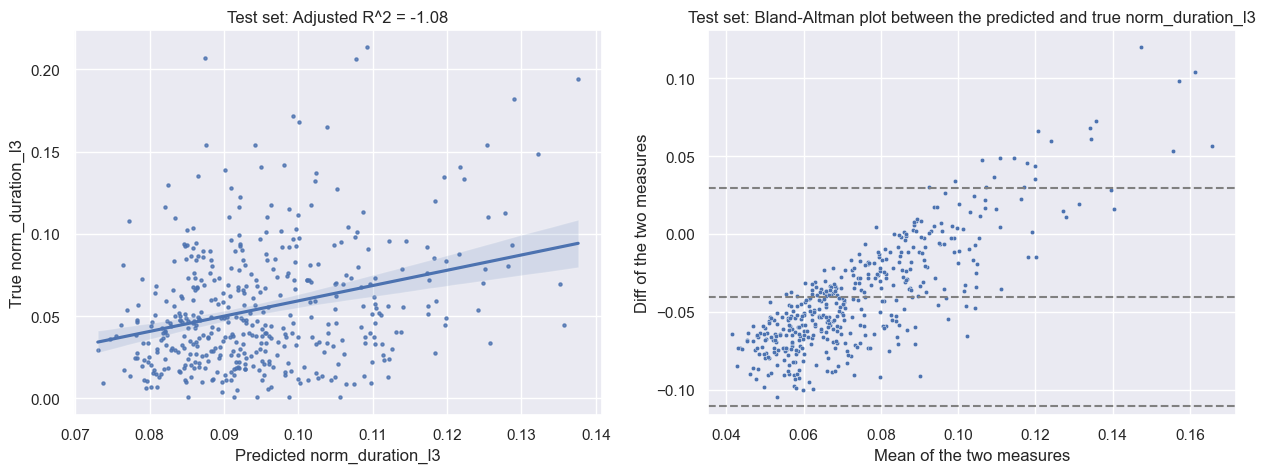

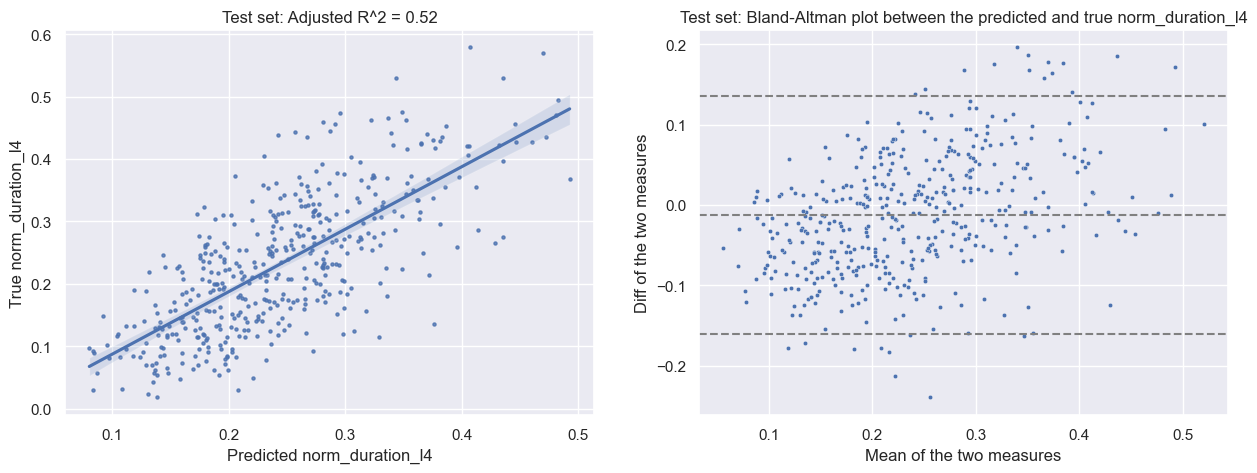

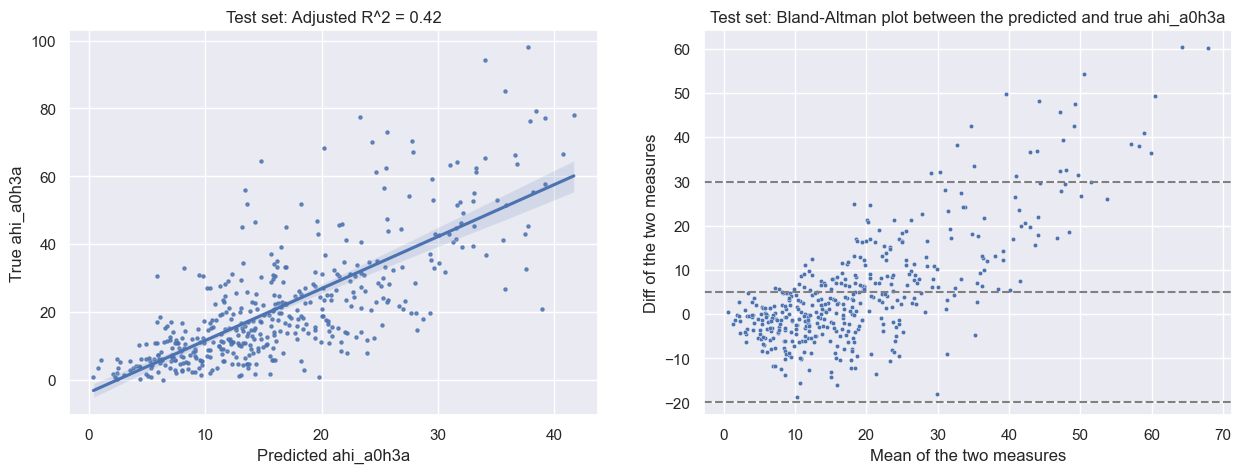

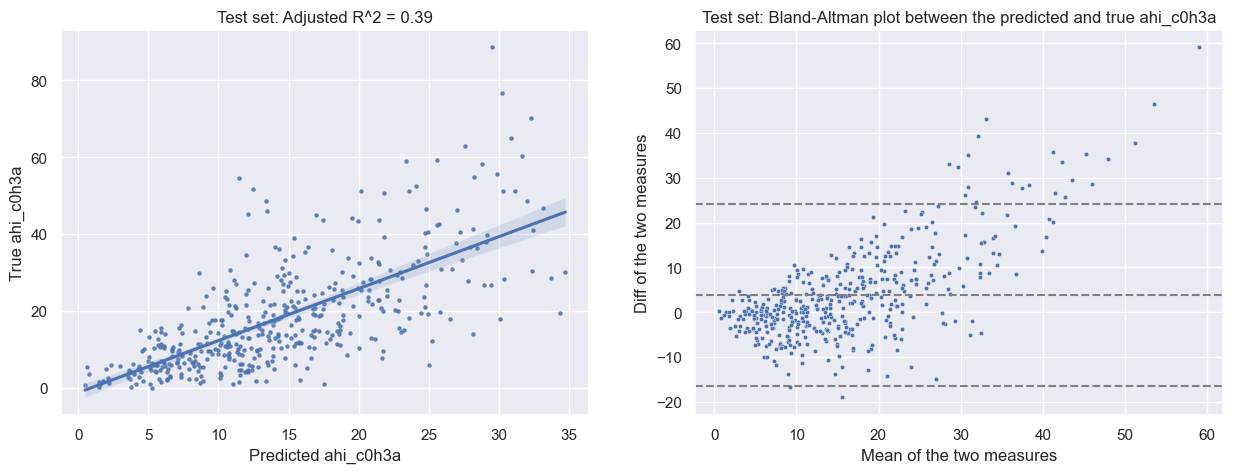

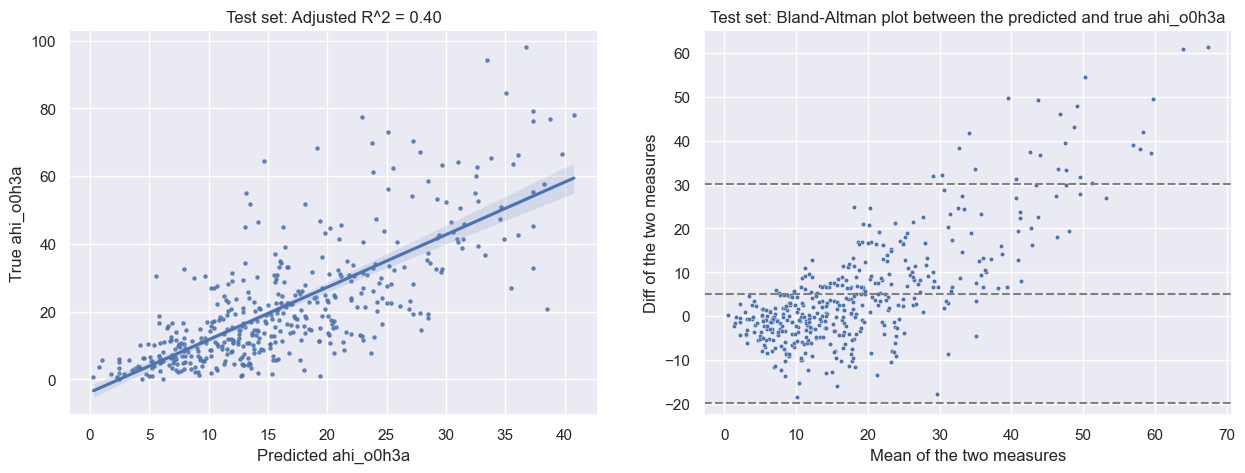

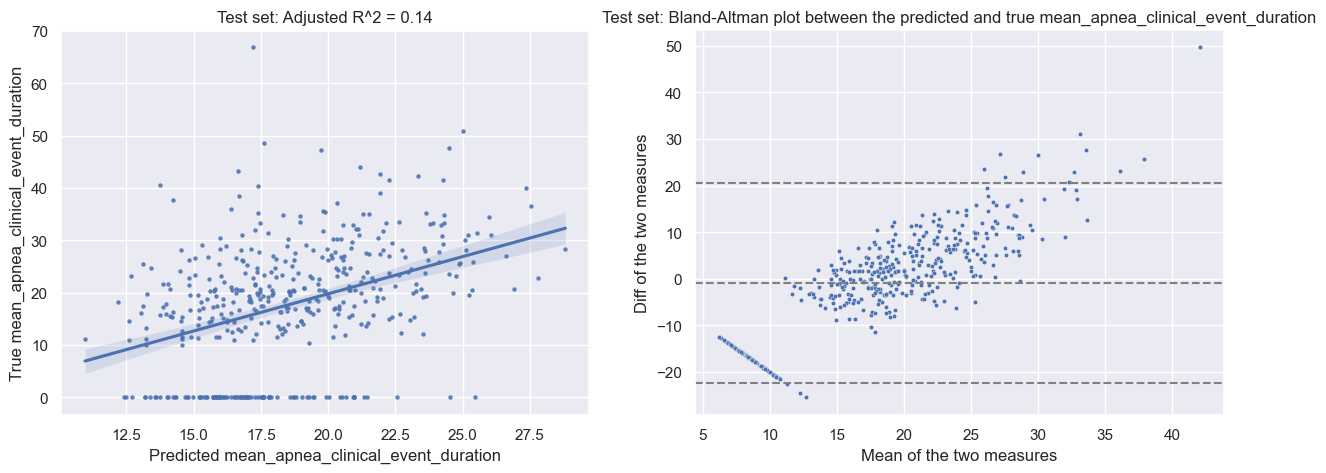

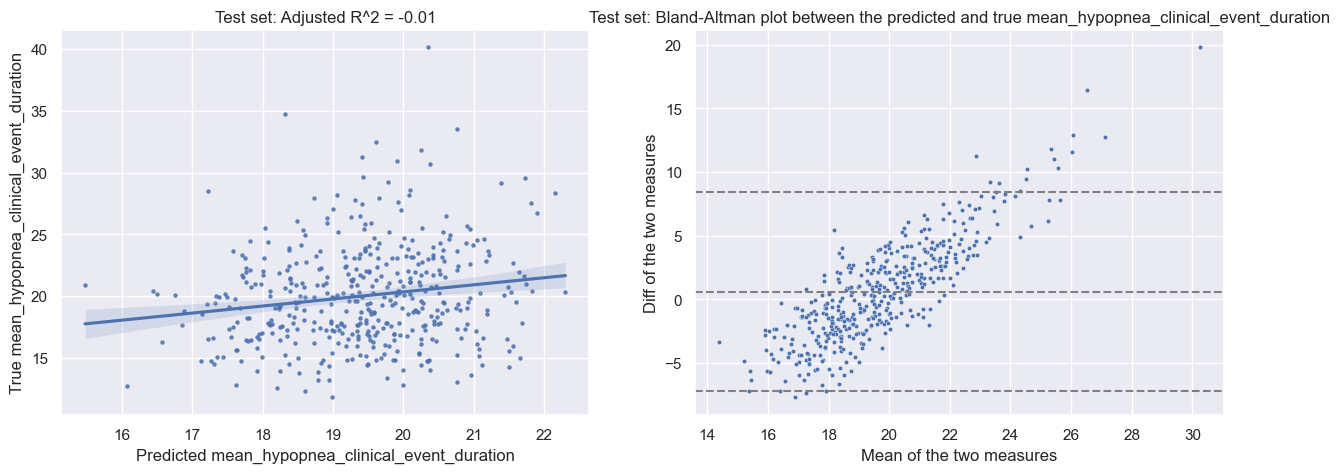

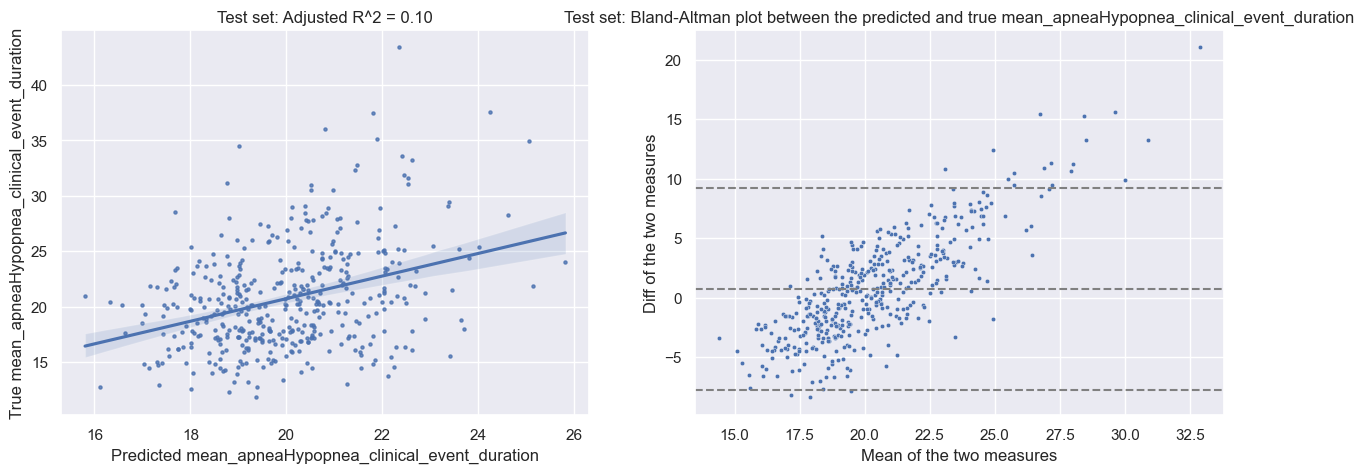

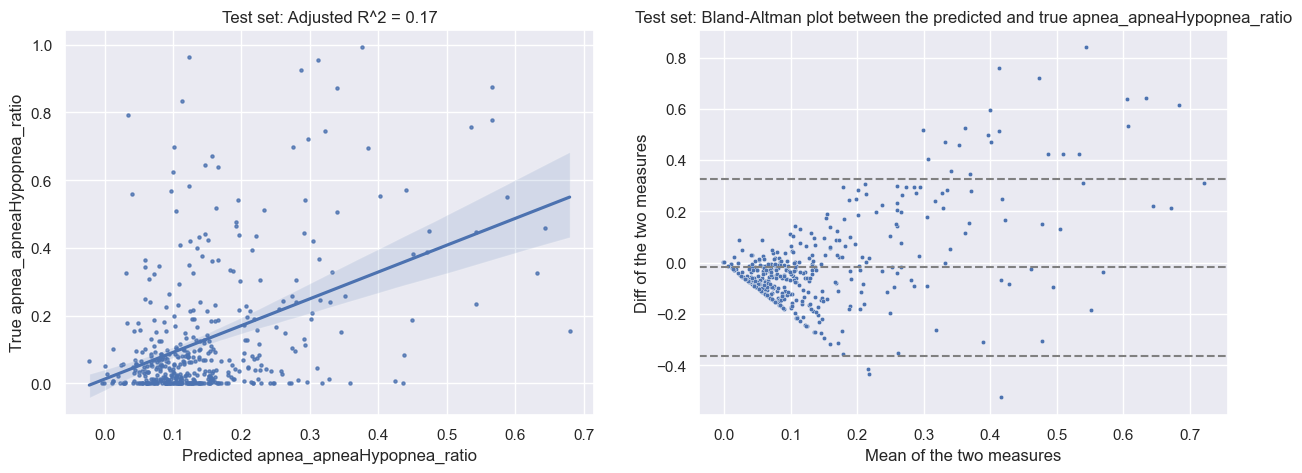

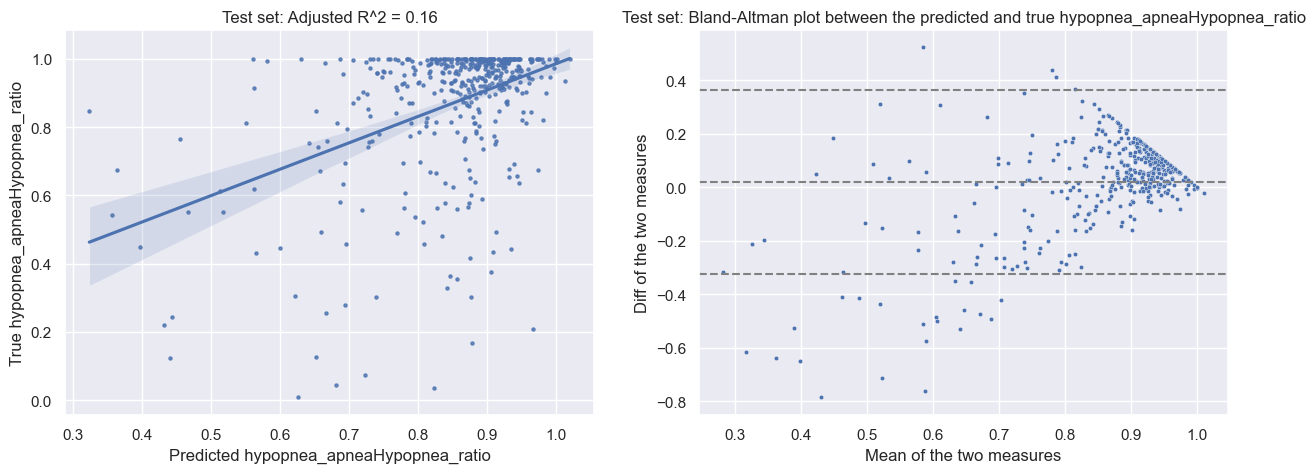

In [106]:
if REGRESSION:

    for i in range(len(regression_columns)):
        print("-------------------------------------------------")
        column_name = regression_columns[i]
        print(f"Regression on {column_name}")
        
        
        parameters = {'max_depth': None,
                    'max_features': 'sqrt',
                    'min_samples_leaf': 1,
                    'min_samples_split': 4,
                    'n_estimators': 100} 
        mddel = RandomForestRegressor(random_state=33, **parameters)
        model.fit(X_train, Y_train_reg[:, i])
        mdl = model

        
        y_hat = mdl.predict(X_test)
        y_true = Y_test_reg[:, i]

        y_hat_clas = ahi_to_category_vf(y_hat)
        y_true_clas = Y_test_clas
        
        r2 = r2_score(y_true=y_true, y_pred=y_hat)
        mae = mean_absolute_error(y_true=y_true, y_pred=y_hat)
        rmse = mean_squared_error(y_true=y_true, y_pred=y_hat, squared=False)
        y_mean = np.mean(y_true)
        accuracy = accuracy_score(y_true=y_true_clas, y_pred=y_hat_clas)
        macro_f1 = f1_score(y_true=y_true_clas, y_pred=y_hat_clas, average="macro")

        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        sns_df = pd.DataFrame({f"Predicted {column_name}": y_hat, f"True {column_name}": y_true})
        sns.regplot(data=sns_df, x=f"Predicted {column_name}", y=f"True {column_name}", scatter_kws={"s": 5}, ax=axs[0])
        axs[0].set_title(f"Test set: Adjusted R^2 = {r2:.2f}")
        bland_altman_plot(y_true, y_hat, title=f"Test set: Bland-Altman plot between the predicted and true {column_name}", ax=axs[1], kwargs={"s": 10})

        print(f"Test adjusted R^2: {r2:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"CV(RMSE): {100*rmse/y_mean:.2f}%")

### XGBoost

In [107]:
if REGRESSION and not ONLY_LOGISTIC_RIDGE:
    if True:
        model = XGBRegressor(seed=33)

        parameters = {'eta': [0.1,0.2,0.3], 
                    'gamma': [0, 0.05, 0.1],
                    'max_depth':[4, 5, 6],
                    'subsample': [0.7, 0.8, 0.9],
                    'colsample_bytree': [0.7, 0.8, 0.9],
                    'colsample_bynode': [0.7, 0.8, 0.9],
                    'lambda': np.arange(0.7,1.0,0.1),
                    'alpha': np.arange(0.7, 1.0,0.1)}

        clf = RandomizedSearchCV(model, parameters, n_iter=1000, cv=cv_splitter, scoring="r2", refit=True, random_state=33)
        clf.fit(X_train, Y_train_reg[:,ahi_index])

        print(clf.best_score_)
        best_xgbr = clf.best_estimator_
        best_xgbr_params = clf.best_params_
        best_xgbr_params
    else:
        parameters =   {'subsample': 0.8,
                    'max_depth': 6,
                    'lambda': 1.0,
                    'gamma': 0.1,
                    'eta': 0.1,
                    'colsample_bytree': 0.7,
                    'colsample_bynode': 0.9,
                    'alpha': 0.7}
        best_xgbr = XGBRegressor(random_state=33, **parameters)
        best_xgbr.fit(X_train, Y_train_reg[:,ahi_index])
        scores = cross_validate(estimator=best_xgbr, X=X_train, y=Y_train_reg[:,5], scoring='r2', cv=5)["test_score"]
        print(f"Mean cv accuracy: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}, CV: {100*np.std(scores)/abs(np.mean(scores)):2.2f}%")      

In [108]:
if REGRESSION and not ONLY_LOGISTIC_RIDGE:
    mdl = best_xgbr

    y_hat = mdl.predict(X_test)
    y_true = Y_test_reg[:,ahi_index]

    y_hat_clas = ahi_to_category_vf(y_hat)
    y_true_clas = Y_test_clas


    r2 = r2_score(y_true=y_true, y_pred=y_hat)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_hat)
    rmse = mean_squared_error(y_true=y_true, y_pred=y_hat, squared=False)
    y_mean = np.mean(y_true)
    accuracy = accuracy_score(y_true=y_true_clas, y_pred=y_hat_clas)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    sns_df = pd.DataFrame({"Predicted AHI": y_hat, "True AHI": y_true})
    sns.regplot(data=sns_df, x="Predicted AHI", y="True AHI", scatter_kws={"s": 5}, ax=axs[0])
    axs[0].set_title(f"Adjusted R^2 = {r2:.2f}")
    bland_altman_plot(y_true, y_hat, title="Bland-Altman plot between the predicted and true AHI", ax=axs[1], kwargs={"s": 10})

    print(f"Test R^2: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"CV(RMSE): {100*rmse/y_mean:.2f}%")
    print("---------------------------------------------------------------")
    classification_performance(y_true_clas, y_hat_clas, test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="true")
    classification_performance(y_true_clas, y_hat_clas, test=True, plot_confusion=True, target_labels=["No", "Mild", "Moderate", "Severe"], normalize="pred")

#### Regression on all columns

-------------------------------------------------
Regression on norm_duration_l0


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.59
MAE: 0.07
CV(RMSE): 12.87%
-------------------------------------------------
Regression on norm_duration_l1


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: -0.01
MAE: 0.00
CV(RMSE): 346.07%
-------------------------------------------------
Regression on norm_duration_l2


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.07
MAE: 0.01
CV(RMSE): 221.66%
-------------------------------------------------
Regression on norm_duration_l3


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.01
MAE: 0.03
CV(RMSE): 68.22%
-------------------------------------------------
Regression on norm_duration_l4


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.54
MAE: 0.06
CV(RMSE): 32.51%
-------------------------------------------------
Regression on ahi_a0h3a


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.61
MAE: 8.16
CV(RMSE): 51.95%
-------------------------------------------------
Regression on ahi_c0h3a


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.48
MAE: 7.49
CV(RMSE): 55.97%
-------------------------------------------------
Regression on ahi_o0h3a


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.60
MAE: 8.22
CV(RMSE): 52.80%
-------------------------------------------------
Regression on mean_apnea_clinical_event_duration


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.11
MAE: 8.64
CV(RMSE): 62.56%
-------------------------------------------------
Regression on mean_hypopnea_clinical_event_duration


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: -0.10
MAE: 3.28
CV(RMSE): 21.05%
-------------------------------------------------
Regression on mean_apneaHypopnea_clinical_event_duration


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.11
MAE: 3.44
CV(RMSE): 21.20%
-------------------------------------------------
Regression on apnea_apneaHypopnea_ratio


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.20
MAE: 0.12
CV(RMSE): 133.30%
-------------------------------------------------
Regression on hypopnea_apneaHypopnea_ratio


c:\Users\filip\anaconda3\envs\apnea-ppg\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Test adjusted R^2: 0.21
MAE: 0.12
CV(RMSE): 19.83%


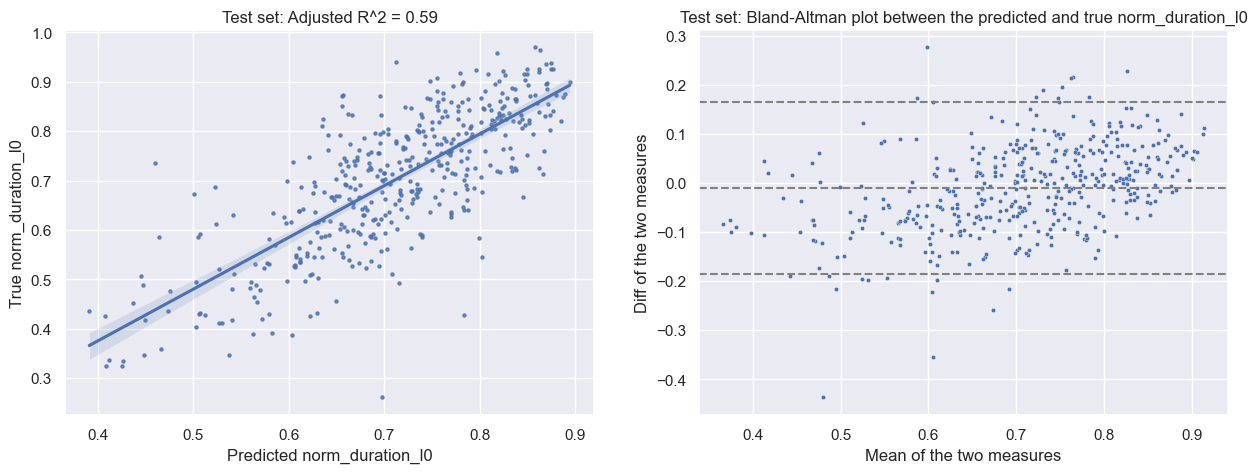

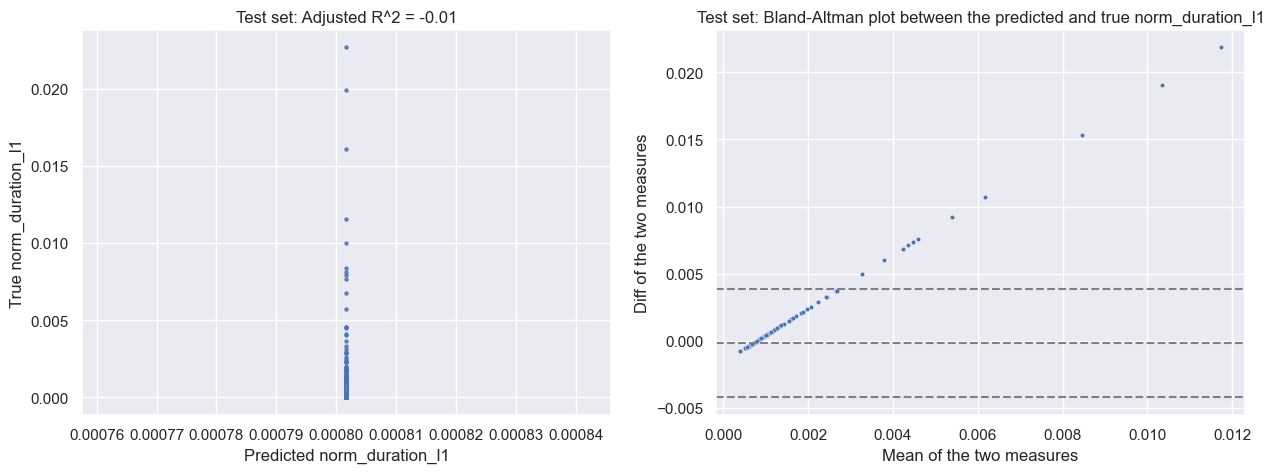

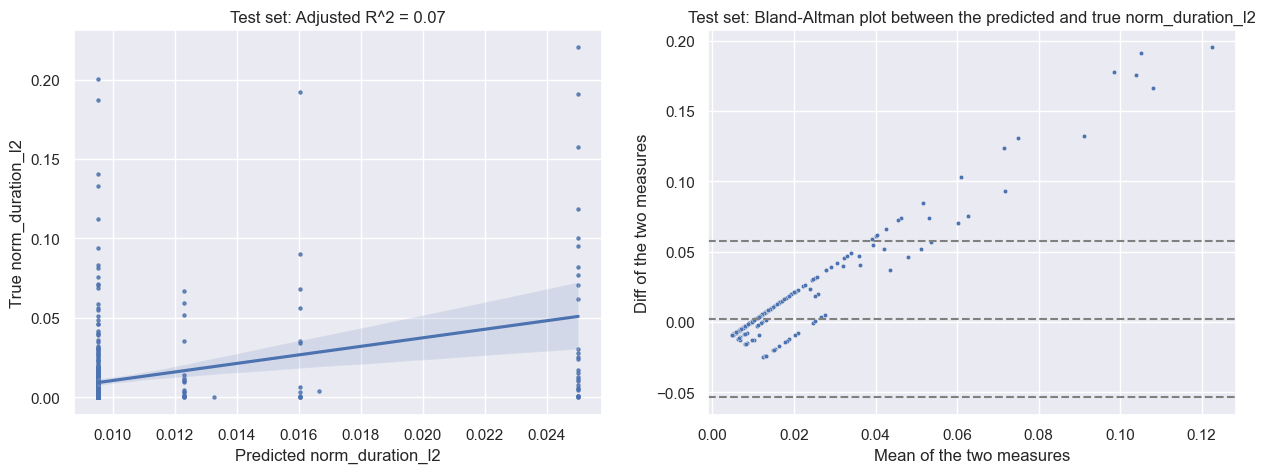

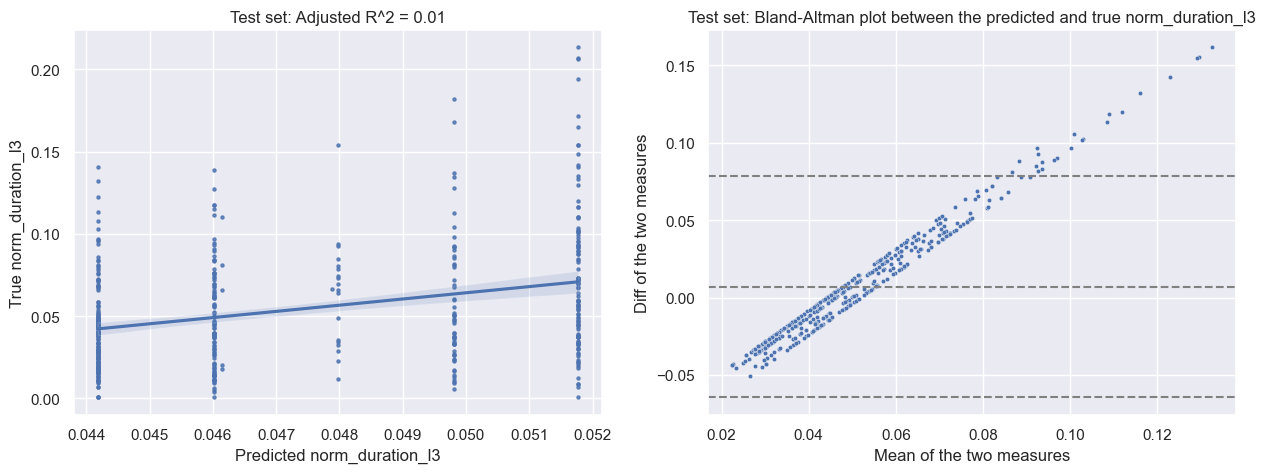

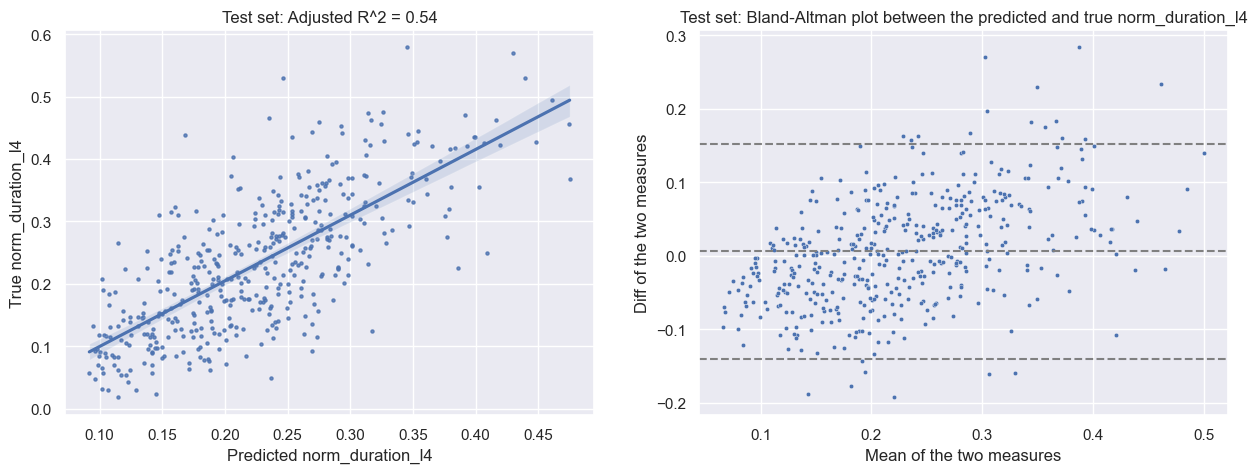

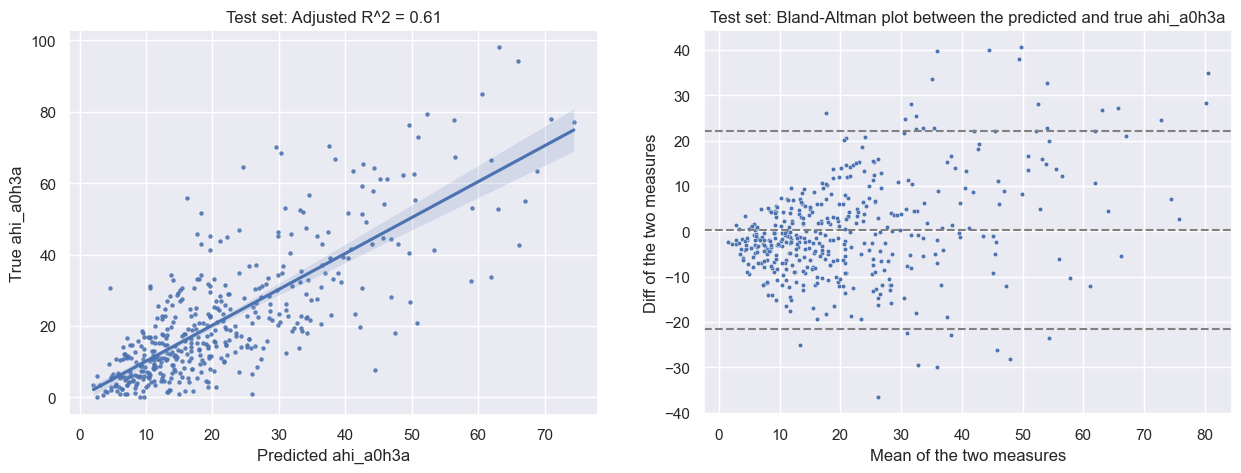

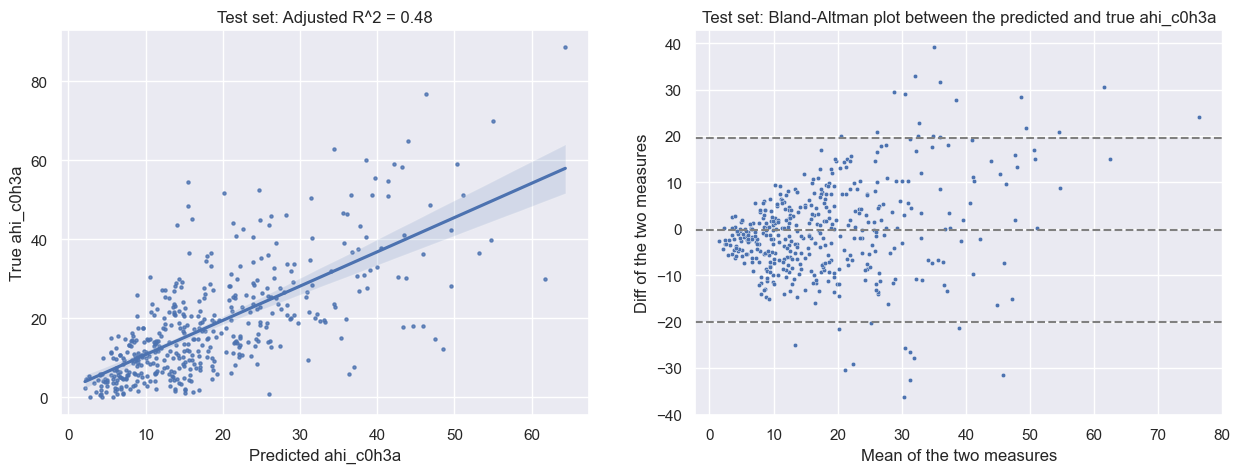

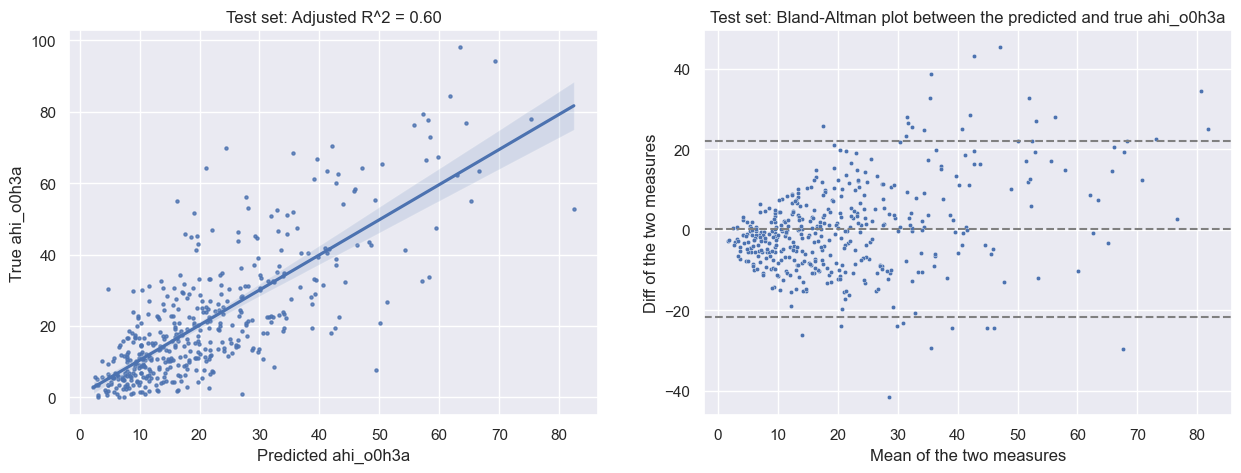

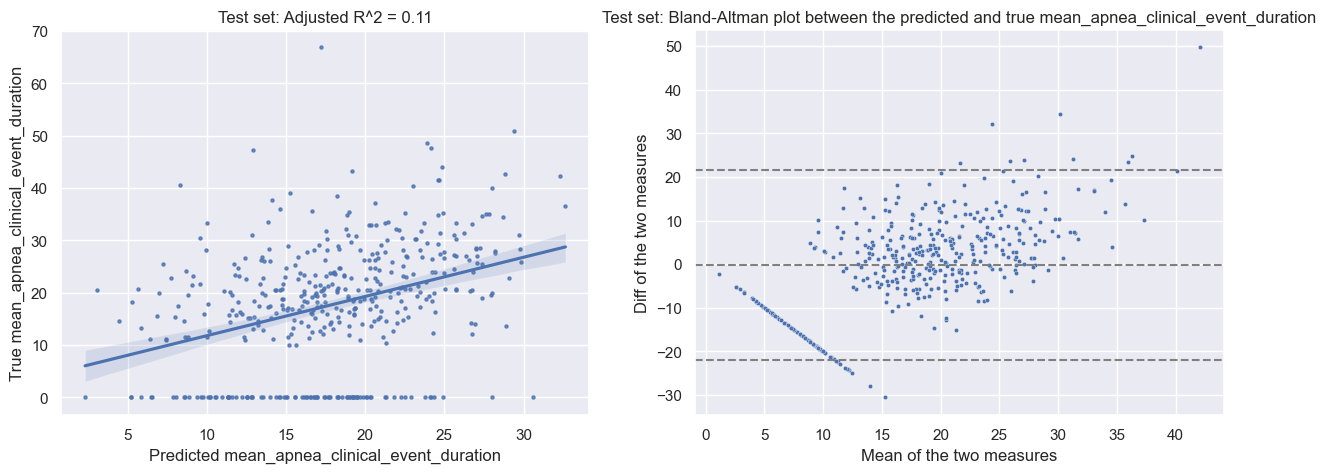

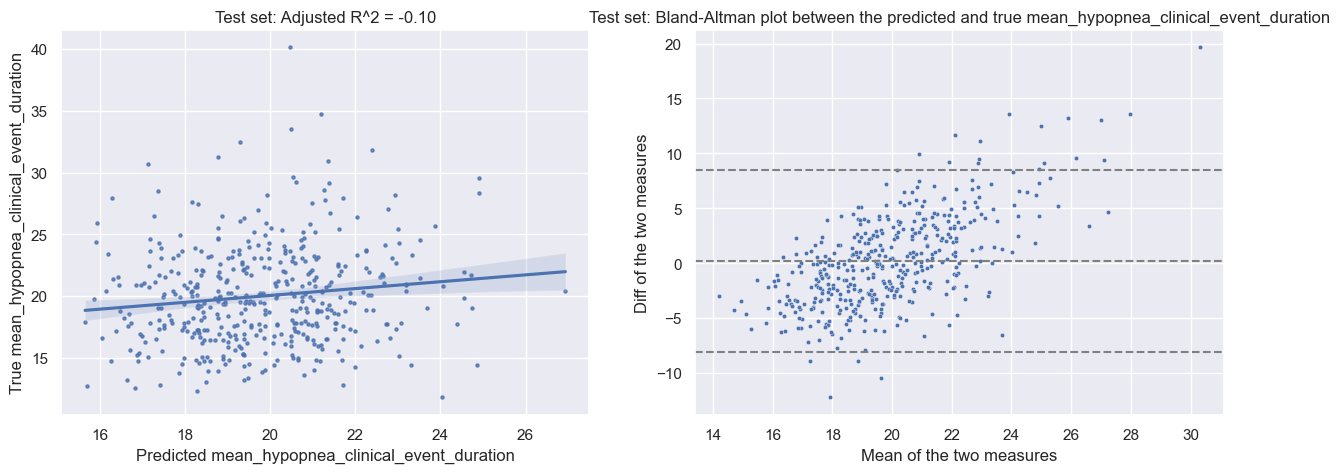

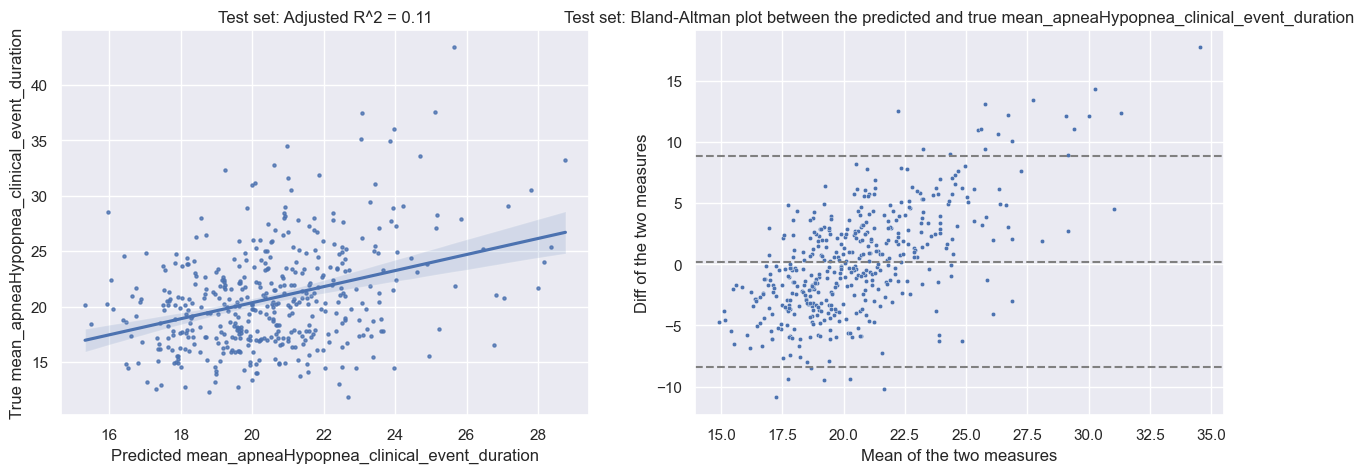

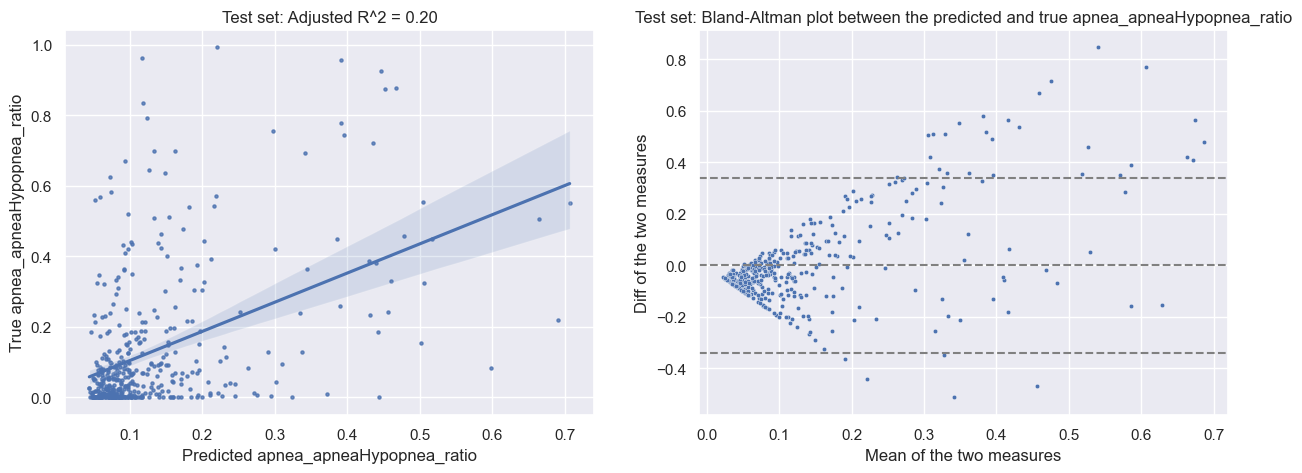

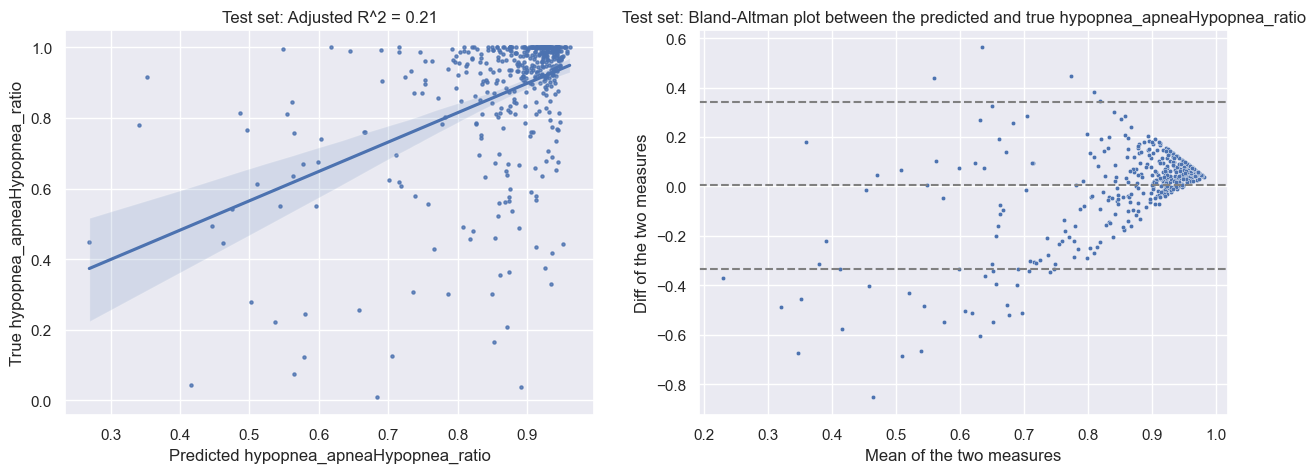

In [109]:
if REGRESSION:

    for i in range(len(regression_columns)):
        print("-------------------------------------------------")
        column_name = regression_columns[i]
        print(f"Regression on {column_name}")
        
        
        parameters =   {'subsample': 0.8,
                    'max_depth': 6,
                    'lambda': 1.0,
                    'gamma': 0.1,
                    'eta': 0.1,
                    'colsample_bytree': 0.7,
                    'colsample_bynode': 0.9,
                    'alpha': 0.7}
        model = XGBRegressor(random_state=33, **parameters)
        model.fit(X_train, Y_train_reg[:, i])
        mdl = model

        
        y_hat = mdl.predict(X_test)
        y_true = Y_test_reg[:, i]

        y_hat_clas = ahi_to_category_vf(y_hat)
        y_true_clas = Y_test_clas
        
        r2 = r2_score(y_true=y_true, y_pred=y_hat)
        mae = mean_absolute_error(y_true=y_true, y_pred=y_hat)
        rmse = mean_squared_error(y_true=y_true, y_pred=y_hat, squared=False)
        y_mean = np.mean(y_true)
        accuracy = accuracy_score(y_true=y_true_clas, y_pred=y_hat_clas)
        macro_f1 = f1_score(y_true=y_true_clas, y_pred=y_hat_clas, average="macro")

        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        sns_df = pd.DataFrame({f"Predicted {column_name}": y_hat, f"True {column_name}": y_true})
        sns.regplot(data=sns_df, x=f"Predicted {column_name}", y=f"True {column_name}", scatter_kws={"s": 5}, ax=axs[0])
        axs[0].set_title(f"Test set: Adjusted R^2 = {r2:.2f}")
        bland_altman_plot(y_true, y_hat, title=f"Test set: Bland-Altman plot between the predicted and true {column_name}", ax=axs[1], kwargs={"s": 10})

        print(f"Test adjusted R^2: {r2:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"CV(RMSE): {100*rmse/y_mean:.2f}%")